In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

## Look at a mix of indexes, ETFs and stocks to analyze the market
Indexes:
^GSPC: S&P 500
^DJI: Dow Jones Industrial Average
^IXIC: NASDAQ Composite
^RUT: Russell 2000

ETFs:
SPY: SPDR S&P 500 ETF Trust
VIT: Vanguard Total Stock Market Index Fund ETF
QQQ: Invesco QQQ Trust (tracks the 100 largest non-financial companies listed on the Nasdaq)
VWO: Vanguard Emerging Markets Stock Index Fund
EFA: iShares MSCI EAFE ETF (tracks the investment results of an index composed of large- and mid-capitalization developed market equities, excluding the US and Canada)

Stocks:
AAPL: Apple
MSFT: Microsoft
NVDA: Nvidia
JPM: JP Morgan
BAC: Bank of America
GS: Goldman Sachs
JNJ: Johnson & Johnson
PFE: Pfizer, Inc.
MRK: Merck & Co.
AMZN: Amazon
TSLA: Tesla
DIS: Disney
BA: Boeing Company
CAT: Caterpillar, Inc.
MMM: 3M Company

In [2]:
indexes = ['^GSPC', '^DJI', '^IXIC', '^RUT', '^SP400', '^SP600']
etfs = ['SPY', 'VTI', 'QQQ', 'VWO', 'EFA']
stocks = ['AAPL', 'MSFT', 'NVDA', 'JPM', 'BAC', 'GS', 'JNJ', 'PFE', 'MRK', 'AMZN', 'TSLA', 'DIS', 'BA', 'CAT', 'MMM']

Classify by sector

In [3]:
sector_classification = {
    'Total Market': ['^GSPC', '^DJI', '^IXIC', '^RUT', 'SPY'],
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'QQQ'],
    'Finance': ['JPM', 'BAC', 'GS'],
    'Healthcare': ['JNJ', 'PFE', 'MRK'],
    'Consumer Discrectionary': ['AMZN', 'TSLA', 'DIS'],
    'Industrials': ['BA', 'CAT', 'MMM'],
    'Emerging Markets': ['VWO'],
    'Developed Markets': ['EFA']
}

In [4]:
events = {
    '2008 Financial Crisis': ('2008-05-01', '2008-12-31'),
    'COVID-19 Market Crash': ('2020-02-19', '2020-03-23')
}

In [5]:
all_tickers = indexes + etfs + stocks

start_date = '2000-01-01'
end_date = '2024-01-01'


historical_data = {}

In [6]:
for ticker in all_tickers:
    historical_data[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## Cleaning and Preprocessing the Data
Start with checking for mising values

In [7]:
missing_values = {}
total_missing_values = 0

In [8]:
for ticker, data in historical_data.items():
    missing_counts = data[['Open', 'High', 'Low', 'Close', 'Volume']].isnull().sum()
    missing_values[ticker] =missing_counts
    total_missing_values += missing_counts.sum()

filtered_missing_values = {}
for ticker, counts in missing_values.items():
    if counts.sum()>0:
        filtered_missing_values[ticker] = counts

if not filtered_missing_values:
    print('No values are missing')
else:
    for ticker, counts in filtered_missing_values.items():
        print(f'{ticker}:')
        print(counts)

No values are missing


In [9]:
def plot_graphs(historical_data, events, sector_classification):
    for sector, tickers in sector_classification.items():
        fig, axs = plt.subplots(len(events), figsize=(10, 6))
        fig.suptitle(sector)

        for i, (event_name, timeframe) in enumerate(events.items()):
            for ticker in tickers:
                if ticker in historical_data:
                    data = historical_data[ticker]
                    # Plot for the event
                    data_during_event = data.loc[timeframe[0]:timeframe[1]]
                    axs[i].plot(data_during_event.index, data_during_event['Adj Close'], label=ticker)

            axs[i].set_title(f'Adj Close During {event_name}')
            axs[i].legend()

        plt.tight_layout()
        plt.show()

In [10]:
# plot_graphs(historical_data, events, sector_classification)

## Adding additional features prior to K-mean clustering
Daily return data
Changes in trading volume data
30 day moving average of adjusted close


In [11]:
for ticker, data in historical_data.items():
    data.index = pd.to_datetime(data.index)
    data['Log Daily Returns'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))
    data['Volume Change'] = data['Volume'].pct_change()
    # data['30-Day MA'] = data['Adj Close'].rolling(window=30).mean()
    data['30-Day Volatility'] = data['Log Daily Returns'].rolling(window=30).std()
    #data['30-Day Volatility Annualized'] = data['30-Day Volatility'] * np.sqrt(252)
    historical_data[ticker] = data

In [12]:
# all features (30 day moving average removed for now)
features = ['Log Daily Returns', 'Volume Change', '30-Day Volatility']
num_of_features = 3

In [13]:
for ticker, data in historical_data.items():
    if data is not None:
        # Cut the first 30 days from the data
        trimmed_data = data.iloc[30:]
        
        trimmed_data['Volume'] = trimmed_data['Volume'].replace(0, np.nan)  # Replace 0 with NaN to avoid dividing by zero
        trimmed_data['Volume'] = trimmed_data['Volume'].fillna(method='ffill').fillna(method='bfill')
        trimmed_data['Volume Change'] = trimmed_data['Volume'].pct_change()
        trimmed_data['Volume Change'].fillna(0, inplace=True)  # Replace NaNs resulted from pct_change
        
        # Now, replace inf with the median for each feature, excluding 'Volume' which was already handled
        for feature in features:
            if feature != 'Volume':  
                median = trimmed_data[feature].replace([np.inf, -np.inf], np.nan).median()
                trimmed_data[feature] = trimmed_data[feature].replace([np.inf, -np.inf], median)
            
            # Recheck for NaN values specifically for other reasons than inf
            has_nan = trimmed_data[feature].isnull().any()
            if has_nan:
                # Fill NaN values with the median, calculated without infs
                trimmed_data[feature].fillna(median, inplace=True)
        
        historical_data[ticker] = trimmed_data

        print(f"Finished processing data for {ticker}.")


Finished processing data for ^GSPC.
Finished processing data for ^DJI.
Finished processing data for ^IXIC.
Finished processing data for ^RUT.
Finished processing data for ^SP400.
Finished processing data for ^SP600.
Finished processing data for SPY.
Finished processing data for VTI.
Finished processing data for QQQ.
Finished processing data for VWO.
Finished processing data for EFA.
Finished processing data for AAPL.
Finished processing data for MSFT.
Finished processing data for NVDA.
Finished processing data for JPM.
Finished processing data for BAC.
Finished processing data for GS.
Finished processing data for JNJ.
Finished processing data for PFE.
Finished processing data for MRK.
Finished processing data for AMZN.
Finished processing data for TSLA.
Finished processing data for DIS.
Finished processing data for BA.
Finished processing data for CAT.
Finished processing data for MMM.


C:\Users\egodd\AppData\Local\Temp\ipykernel_26004\3427208310.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['Volume'] = trimmed_data['Volume'].replace(0, np.nan)  # Replace 0 with NaN to avoid dividing by zero
C:\Users\egodd\AppData\Local\Temp\ipykernel_26004\3427208310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_data['Volume'] = trimmed_data['Volume'].fillna(method='ffill').fillna(method='bfill')
C:\Users\egodd\AppData\Local\Temp\ipykernel_26004\3427208310.py:8: SettingWit

In [14]:
# check data for NaN and Inf values again

for ticker, data in historical_data.items():
    if data is not None:
        data = data.iloc[30:]
        has_nan = data[features].isnull().any()
        has_inf = np.isinf(data[features].values).any(axis=0)  

        if has_nan.any() or has_inf.any():
            print(f"Data for {ticker} contains disruptive values:")
            if has_nan.any():
                print("  Contains NaN values in columns:", has_nan[has_nan].index.tolist())
            if has_inf.any():
                print("  Contains Inf values in columns:", [features[i] for i, x in enumerate(has_inf) if x])
        else:
            print(f"Data for {ticker} is clean.")

Data for ^GSPC is clean.
Data for ^DJI is clean.
Data for ^IXIC is clean.
Data for ^RUT is clean.
Data for ^SP400 is clean.
Data for ^SP600 is clean.
Data for SPY is clean.
Data for VTI is clean.
Data for QQQ is clean.
Data for VWO is clean.
Data for EFA is clean.
Data for AAPL is clean.
Data for MSFT is clean.
Data for NVDA is clean.
Data for JPM is clean.
Data for BAC is clean.
Data for GS is clean.
Data for JNJ is clean.
Data for PFE is clean.
Data for MRK is clean.
Data for AMZN is clean.
Data for TSLA is clean.
Data for DIS is clean.
Data for BA is clean.
Data for CAT is clean.
Data for MMM is clean.


## Save Preprocessed Data as CSV Files

In [15]:
for ticker in historical_data:
    historical_data[ticker].to_csv(f"{ticker}_clean.csv")

## Correlation Between Features During Black Swan Events

Load CSV function

In [16]:
def load_csv_data(ticker):
    try:
        return pd.read_csv(f"{ticker}_clean.csv", index_col='Date', parse_dates=True)
    except FileNotFoundError:
        print(f"Data file for {ticker} not found.")
        return None

In [17]:
gspc_data = load_csv_data('^GSPC')
if gspc_data is not None:
    print(gspc_data.head())  
    print(gspc_data.index.min(), gspc_data.index.max())
else:
    print("Failed to load data for ^GSPC.")

print(f"Index type: {type(gspc_data.index)}")

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2000-02-15  1389.939941  1407.719971  1376.250000  1402.050049  1402.050049   
2000-02-16  1402.050049  1404.550049  1385.579956  1387.670044  1387.670044   
2000-02-17  1387.670044  1399.880005  1380.069946  1388.260010  1388.260010   
2000-02-18  1388.260010  1388.589966  1345.319946  1346.089966  1346.089966   
2000-02-22  1346.089966  1358.109985  1331.880005  1352.170044  1352.170044   

                Volume  Log Daily Returns  Volume Change  30-Day Volatility  
Date                                                                         
2000-02-15  1092100000           0.008675       0.000000           0.014975  
2000-02-16  1018800000          -0.010309      -0.067118           0.013294  
2000-02-17  1034800000           0.000425       0.015705           0.013288  
2000-02-18  1042300000          -0.030847       0.007248

Plot Features function

Calculate correlations for a sector function

In [18]:
def calculate_correlations(ticker, ticker_data, market_data, event_name, start_date, end_date):
    period_ticker_data = ticker_data.loc[start_date:end_date]
    period_market_data = market_data.loc[start_date:end_date]
    combined_data = pd.concat([
        period_ticker_data[features],
        period_market_data[['Log Daily Returns']].rename(columns={'Log Daily Returns': 'Market Log Daily Returns'})
    ], axis=1)
    correlation_matrix = combined_data.corr()
    print(f'Correlations for {ticker} during {event_name}:\n{correlation_matrix}\n')

In [19]:
gspc_data = load_csv_data('^GSPC')
aapl_data = load_csv_data('AAPL')

for event_name, (start_date, end_date) in events.items():
    calculate_correlations('AAPL', aapl_data, gspc_data, event_name, start_date, end_date)


Correlations for AAPL during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.172261          -0.006557   
Volume Change                     -0.172261       1.000000           0.011365   
30-Day Volatility                 -0.006557       0.011365           1.000000   
Market Log Daily Returns           0.724433      -0.167714          -0.036583   

                          Market Log Daily Returns  
Log Daily Returns                         0.724433  
Volume Change                            -0.167714  
30-Day Volatility                        -0.036583  
Market Log Daily Returns                  1.000000  

Correlations for AAPL during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.489600          -0.079881   
Volume Change                     -0.489600       1.000000    

In [20]:
sector_data = {}

for sector, tickers in sector_classification.items():
    sector_dfs = []  
    for ticker in tickers:
        ticker_data = load_csv_data(ticker)
        if ticker_data is not None:  
            sector_dfs.append(ticker_data)
    if sector_dfs:
        # Concatenate all the DataFrames for the sector and calculate the mean for each day
        sector_data[sector] = pd.concat(sector_dfs).groupby(level=0).mean()

# check that the market data is loaded for correlation comparison
market_data = load_csv_data('^GSPC')


In [21]:
def plot_sector_features(sector, sector_tickers_data, event_name, start_date, end_date, market_data):
    fig, axs = plt.subplots(num_of_features, 1, figsize=(14, 14), sharex=True)  # One subplot for each feature
    fig.suptitle(f'{sector} Sector and ^GSPC during {event_name}', fontsize=16)

    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    # Include ^GSPC in each subplot for comparison
    for feature_num, feature in enumerate(features):
        for ticker, data in sector_tickers_data.items():
            if data is not None:
                color_index = list(sector_tickers_data.keys()).index(ticker) % len(colors)
                axs[feature_num].plot(data.loc[start_date:end_date, feature], label=ticker, color=colors[color_index])
        
        # Plot ^GSPC data in black
        axs[feature_num].plot(market_data.loc[start_date:end_date, feature], label='^GSPC', color='black', linewidth=2.0)
        axs[feature_num].set_ylabel(feature)
        axs[feature_num].legend(loc='upper left')
    
    axs[-1].set_xlabel('Date')  # x-labels
    plt.show()

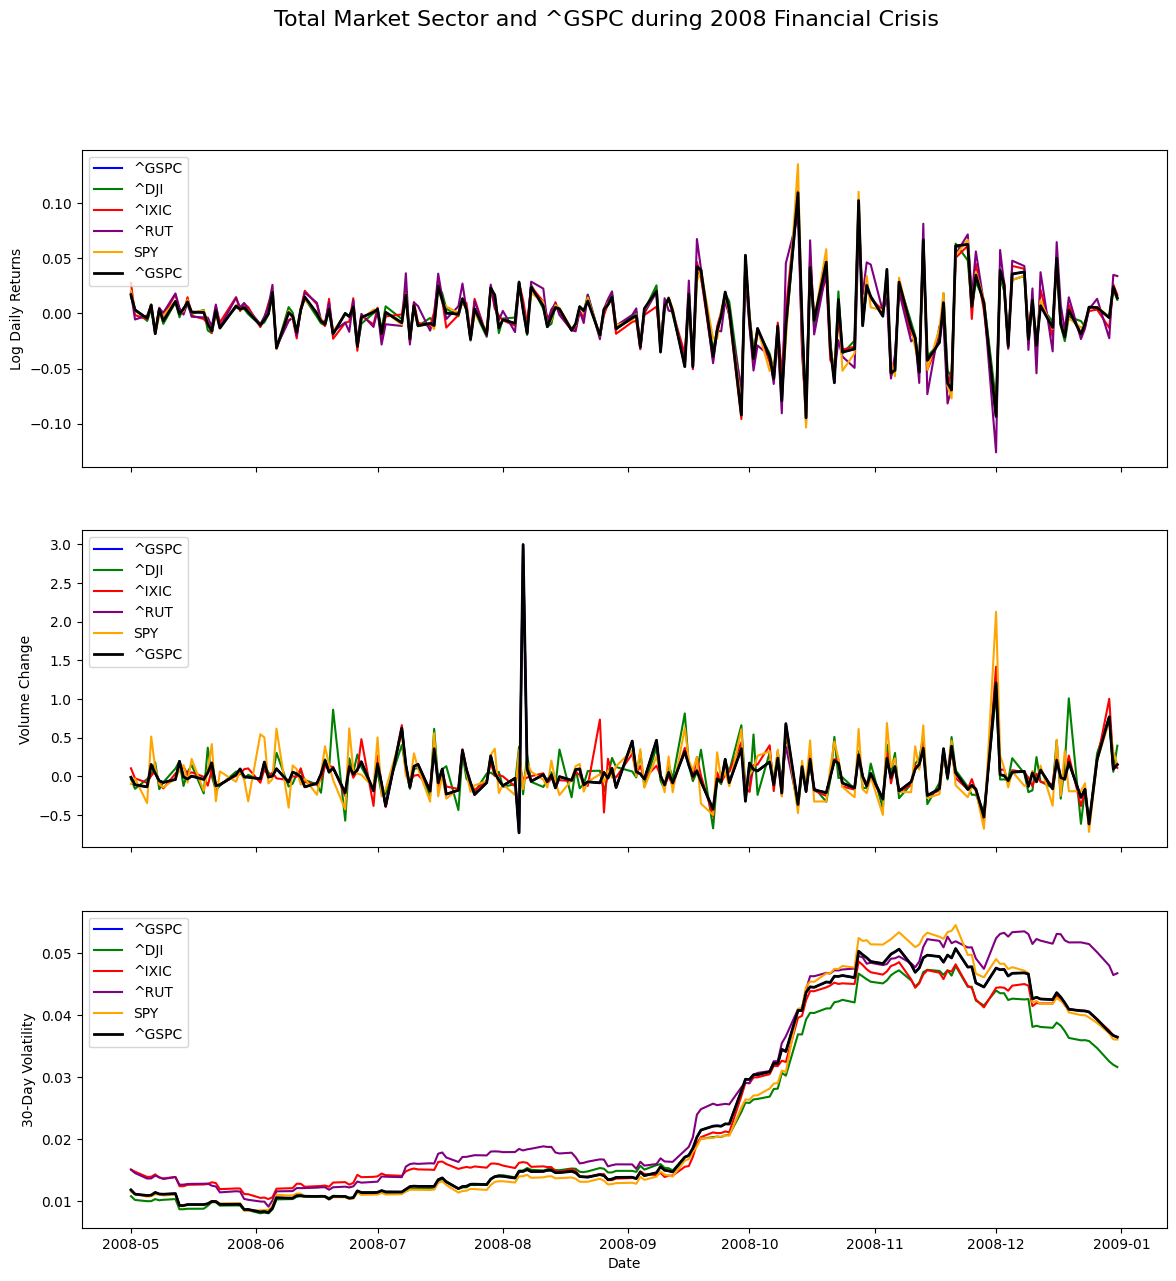

Correlations for Total Market during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.129801          -0.010155   
Volume Change                     -0.129801       1.000000           0.011556   
30-Day Volatility                 -0.010155       0.011556           1.000000   
Market Log Daily Returns           0.993330      -0.133913          -0.003651   

                          Market Log Daily Returns  
Log Daily Returns                         0.993330  
Volume Change                            -0.133913  
30-Day Volatility                        -0.003651  
Market Log Daily Returns                  1.000000  



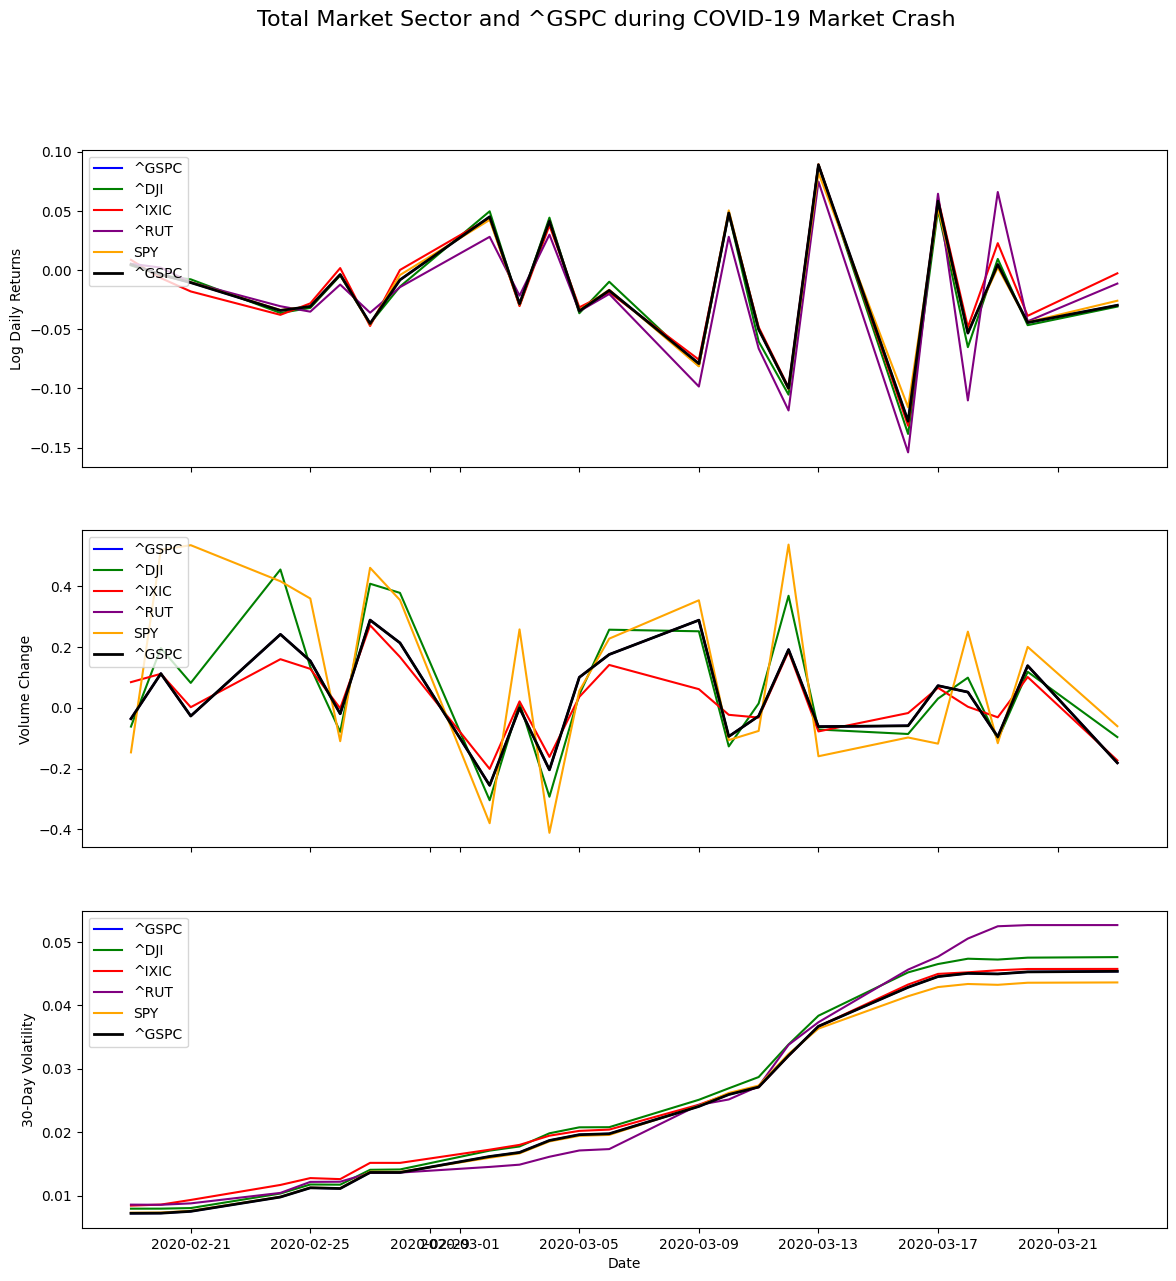

Correlations for Total Market during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.490813          -0.111952   
Volume Change                     -0.490813       1.000000          -0.263684   
30-Day Volatility                 -0.111952      -0.263684           1.000000   
Market Log Daily Returns           0.994767      -0.491914          -0.122314   

                          Market Log Daily Returns  
Log Daily Returns                         0.994767  
Volume Change                            -0.491914  
30-Day Volatility                        -0.122314  
Market Log Daily Returns                  1.000000  



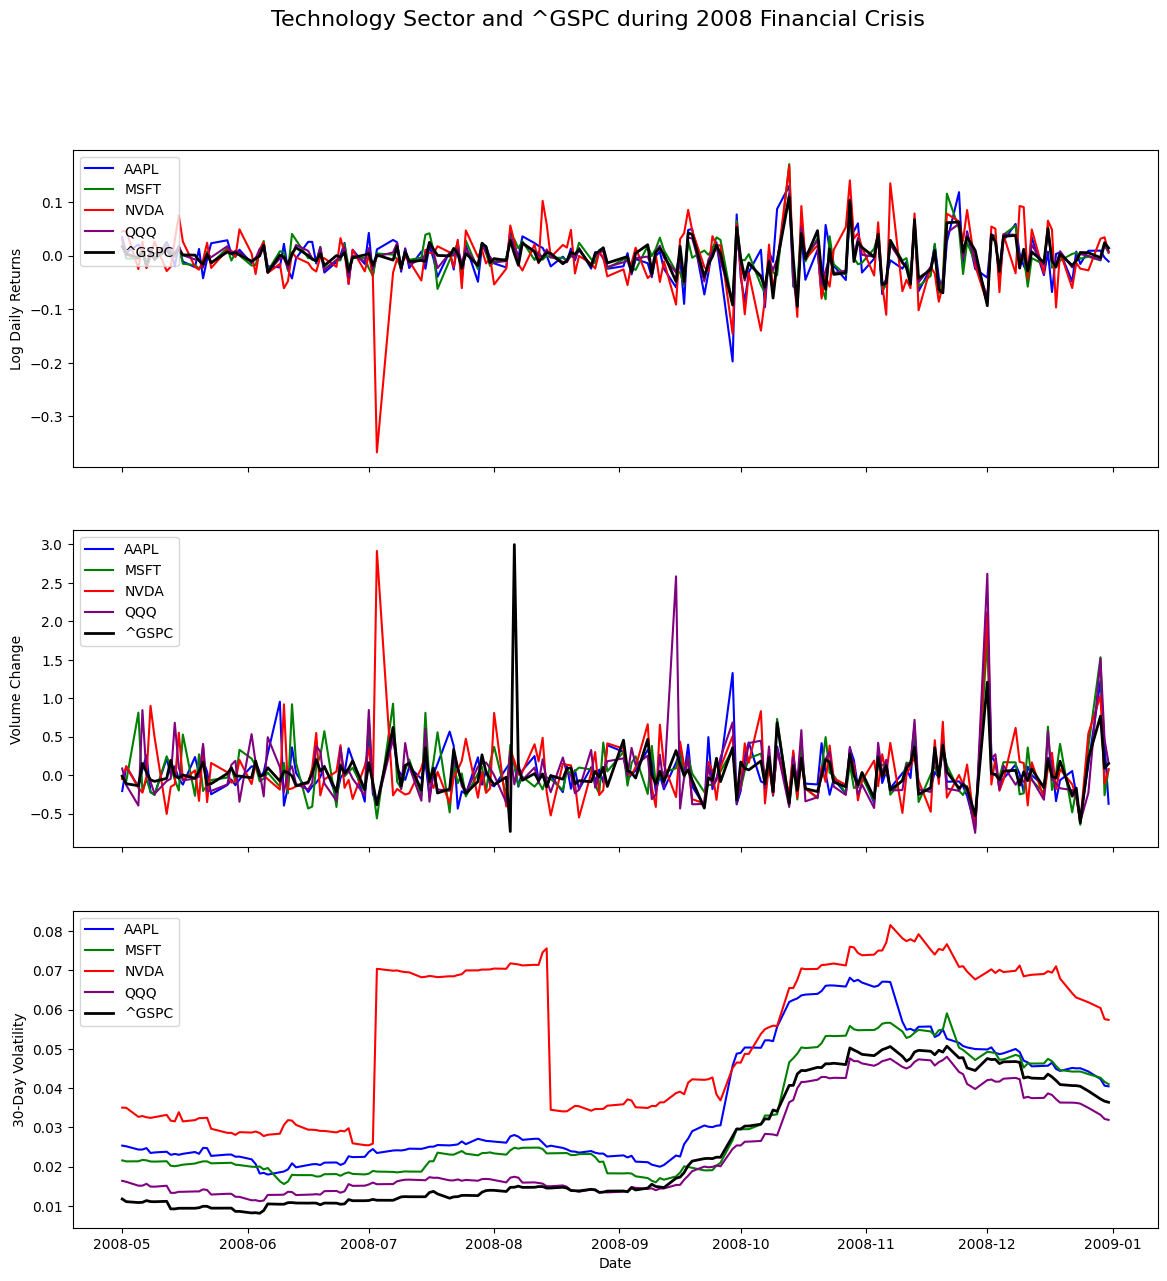

Correlations for Technology during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.149917           0.026896   
Volume Change                     -0.149917       1.000000          -0.000885   
30-Day Volatility                  0.026896      -0.000885           1.000000   
Market Log Daily Returns           0.881859      -0.181775           0.004868   

                          Market Log Daily Returns  
Log Daily Returns                         0.881859  
Volume Change                            -0.181775  
30-Day Volatility                         0.004868  
Market Log Daily Returns                  1.000000  



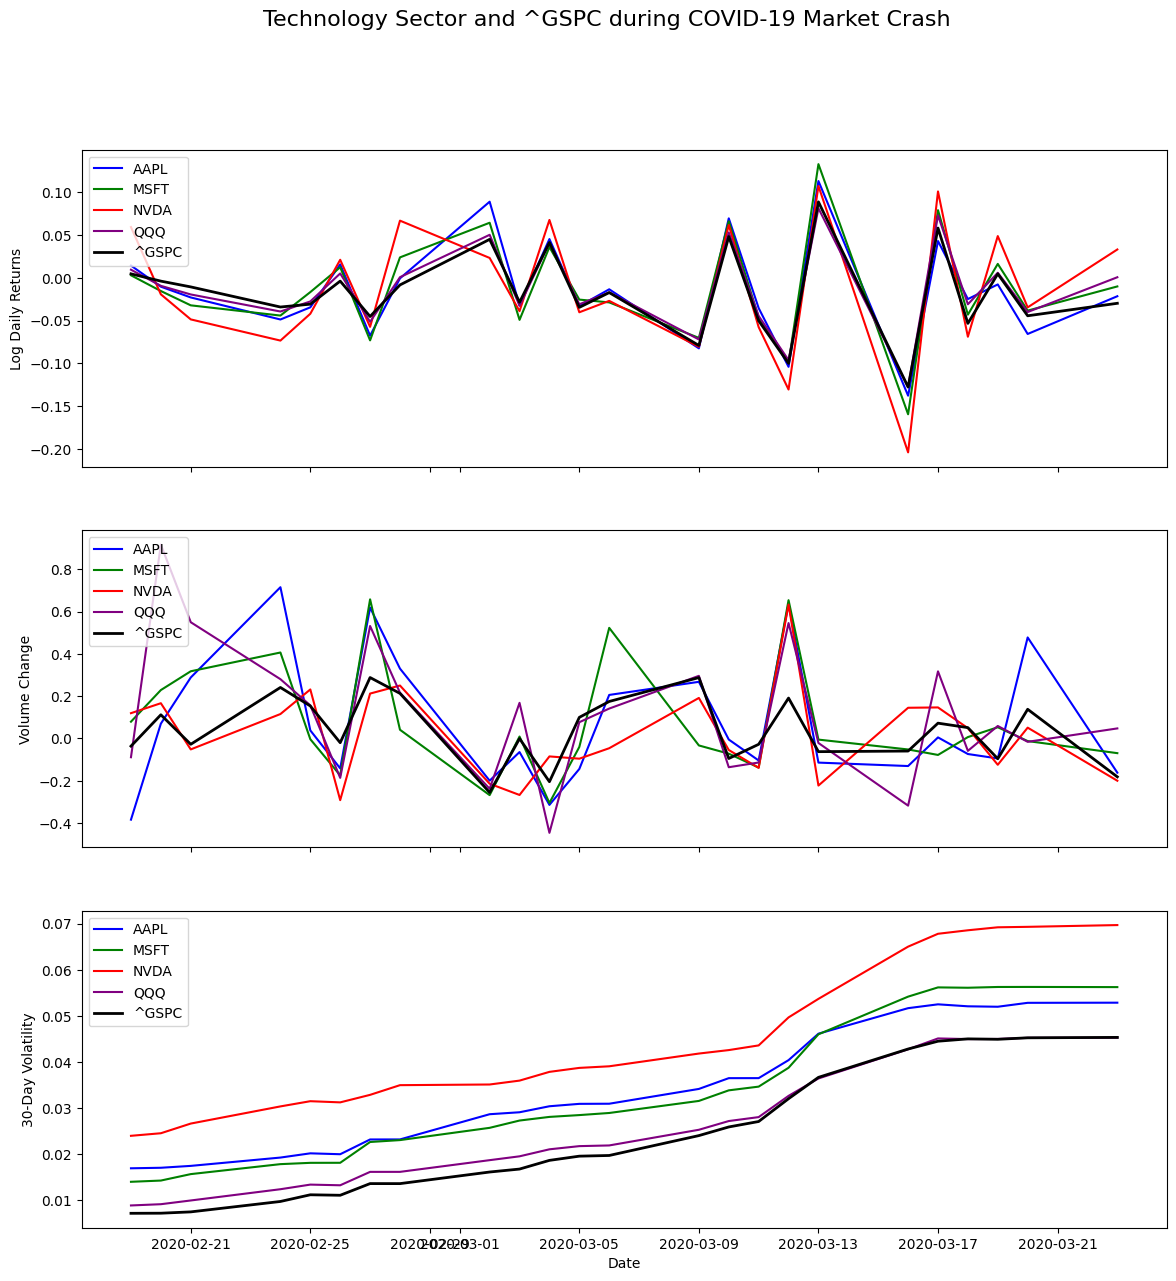

Correlations for Technology during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.449396          -0.034916   
Volume Change                     -0.449396       1.000000          -0.213481   
30-Day Volatility                 -0.034916      -0.213481           1.000000   
Market Log Daily Returns           0.975753      -0.391245          -0.109861   

                          Market Log Daily Returns  
Log Daily Returns                         0.975753  
Volume Change                            -0.391245  
30-Day Volatility                        -0.109861  
Market Log Daily Returns                  1.000000  



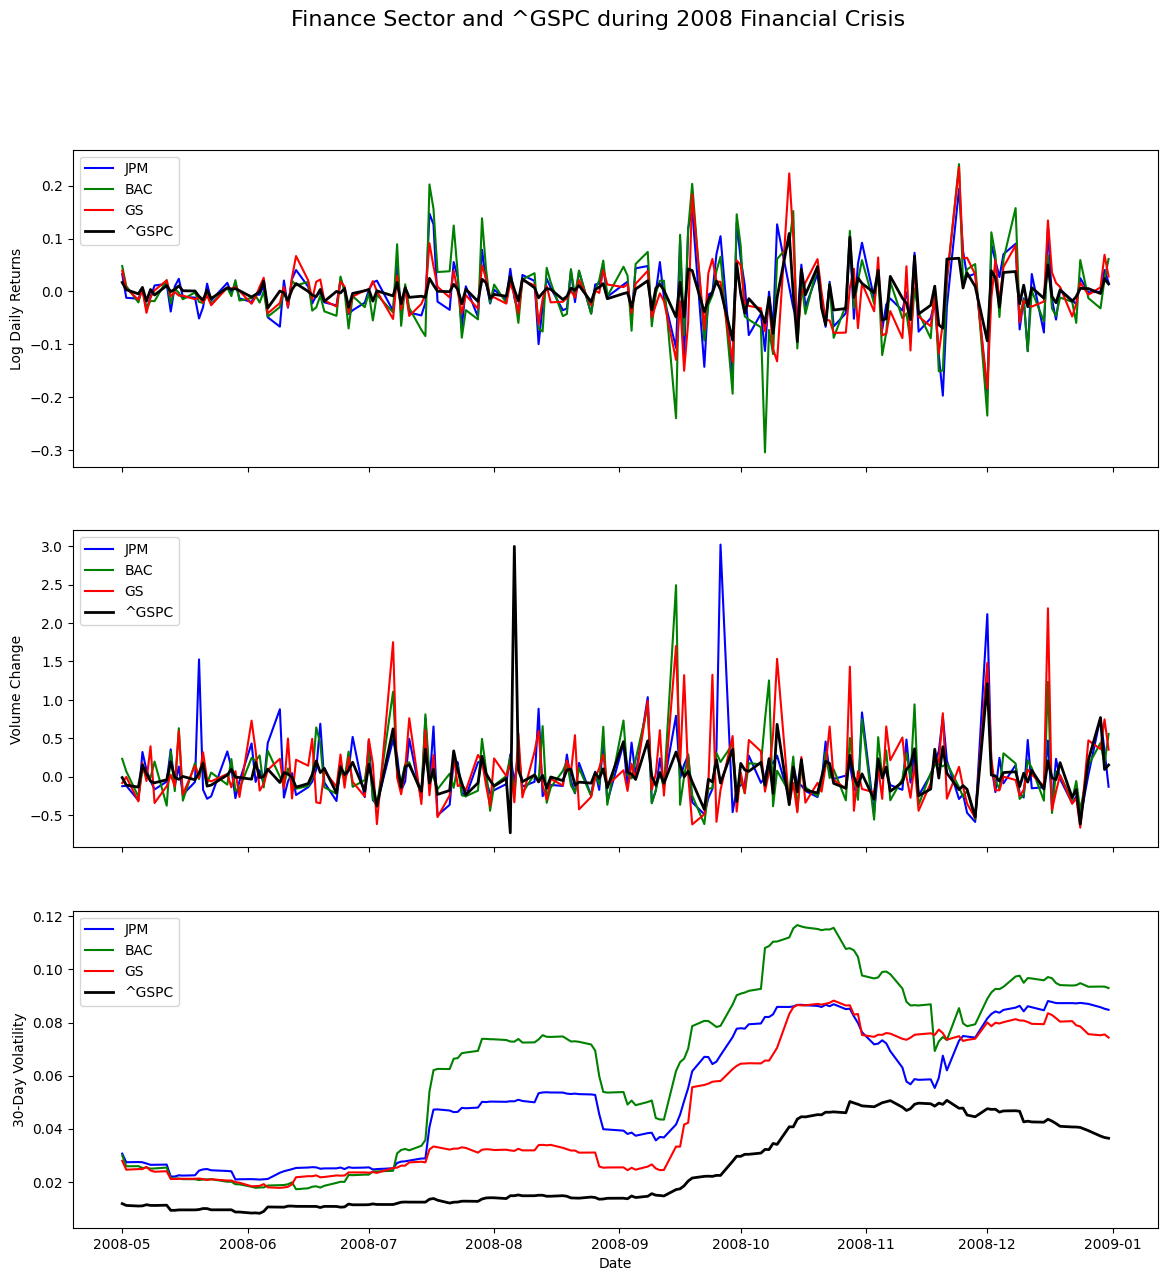

Correlations for Finance during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.165741          -0.004750   
Volume Change                     -0.165741       1.000000          -0.011592   
30-Day Volatility                 -0.004750      -0.011592           1.000000   
Market Log Daily Returns           0.822393      -0.084293          -0.018699   

                          Market Log Daily Returns  
Log Daily Returns                         0.822393  
Volume Change                            -0.084293  
30-Day Volatility                        -0.018699  
Market Log Daily Returns                  1.000000  



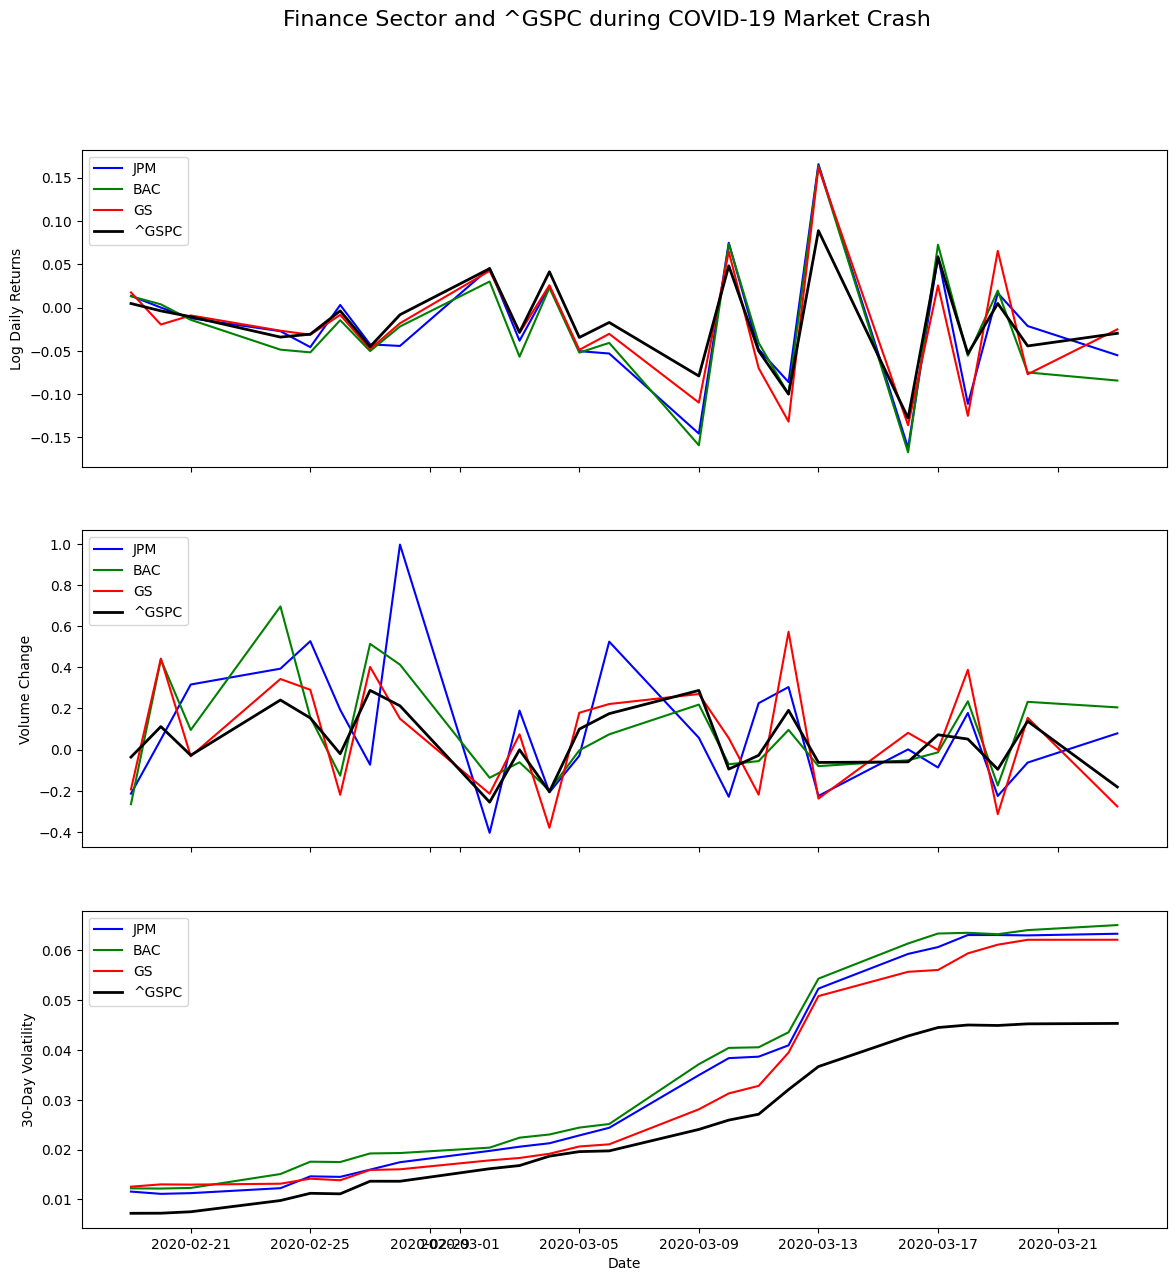

Correlations for Finance during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.513760          -0.067544   
Volume Change                     -0.513760       1.000000          -0.252486   
30-Day Volatility                 -0.067544      -0.252486           1.000000   
Market Log Daily Returns           0.957832      -0.500684          -0.106435   

                          Market Log Daily Returns  
Log Daily Returns                         0.957832  
Volume Change                            -0.500684  
30-Day Volatility                        -0.106435  
Market Log Daily Returns                  1.000000  



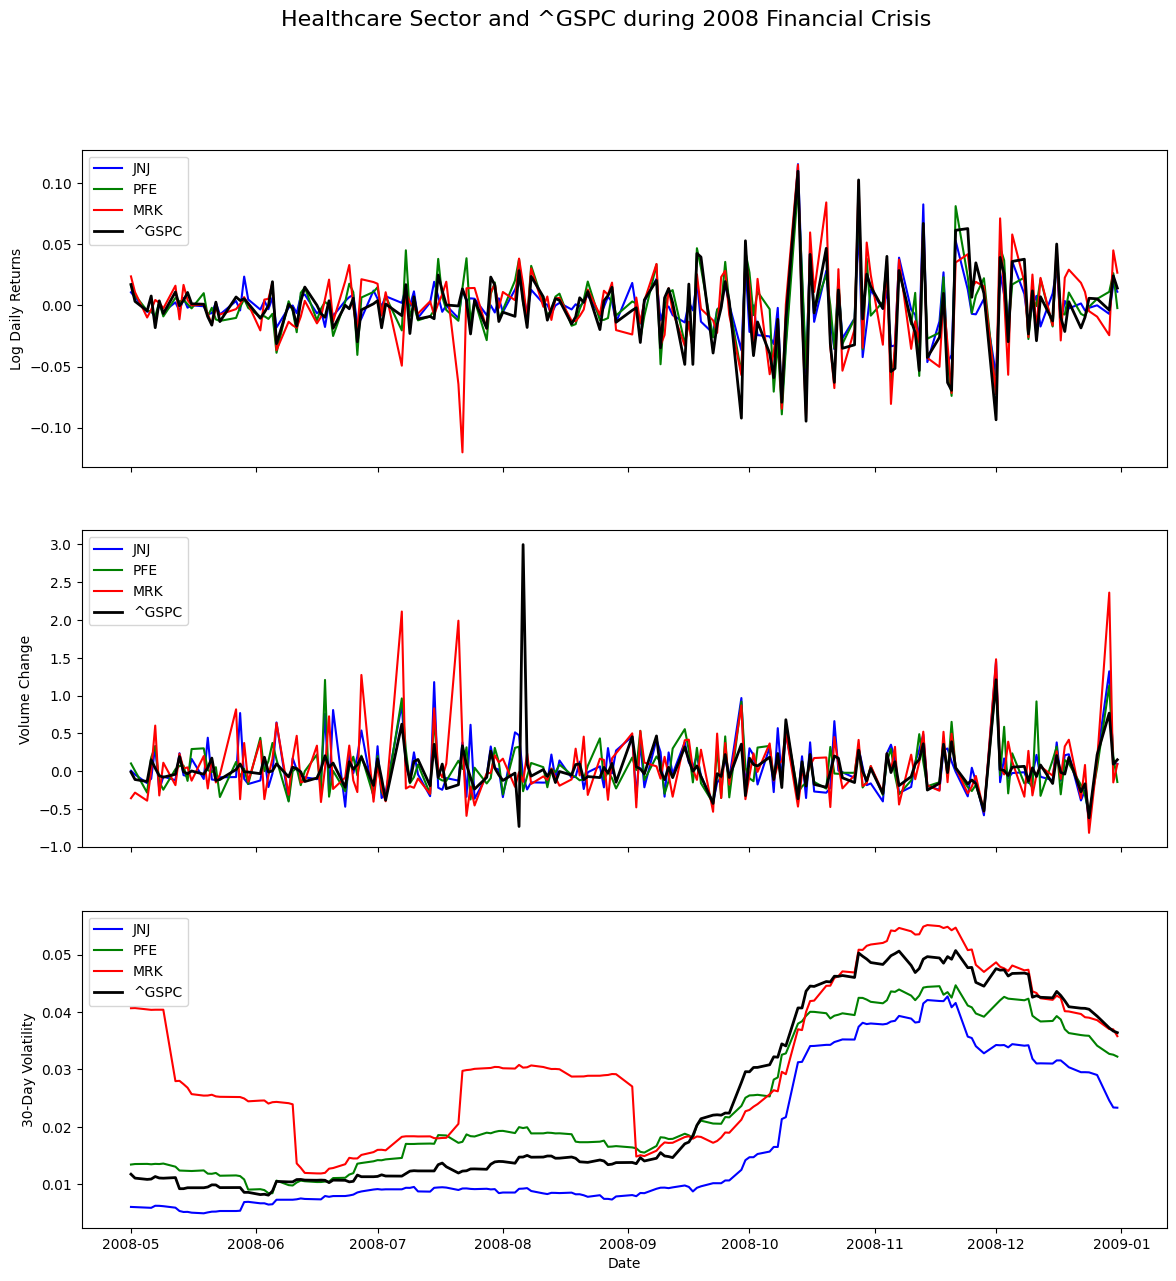

Correlations for Healthcare during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.191839           0.032352   
Volume Change                     -0.191839       1.000000          -0.029425   
30-Day Volatility                  0.032352      -0.029425           1.000000   
Market Log Daily Returns           0.909162      -0.198105           0.019371   

                          Market Log Daily Returns  
Log Daily Returns                         0.909162  
Volume Change                            -0.198105  
30-Day Volatility                         0.019371  
Market Log Daily Returns                  1.000000  



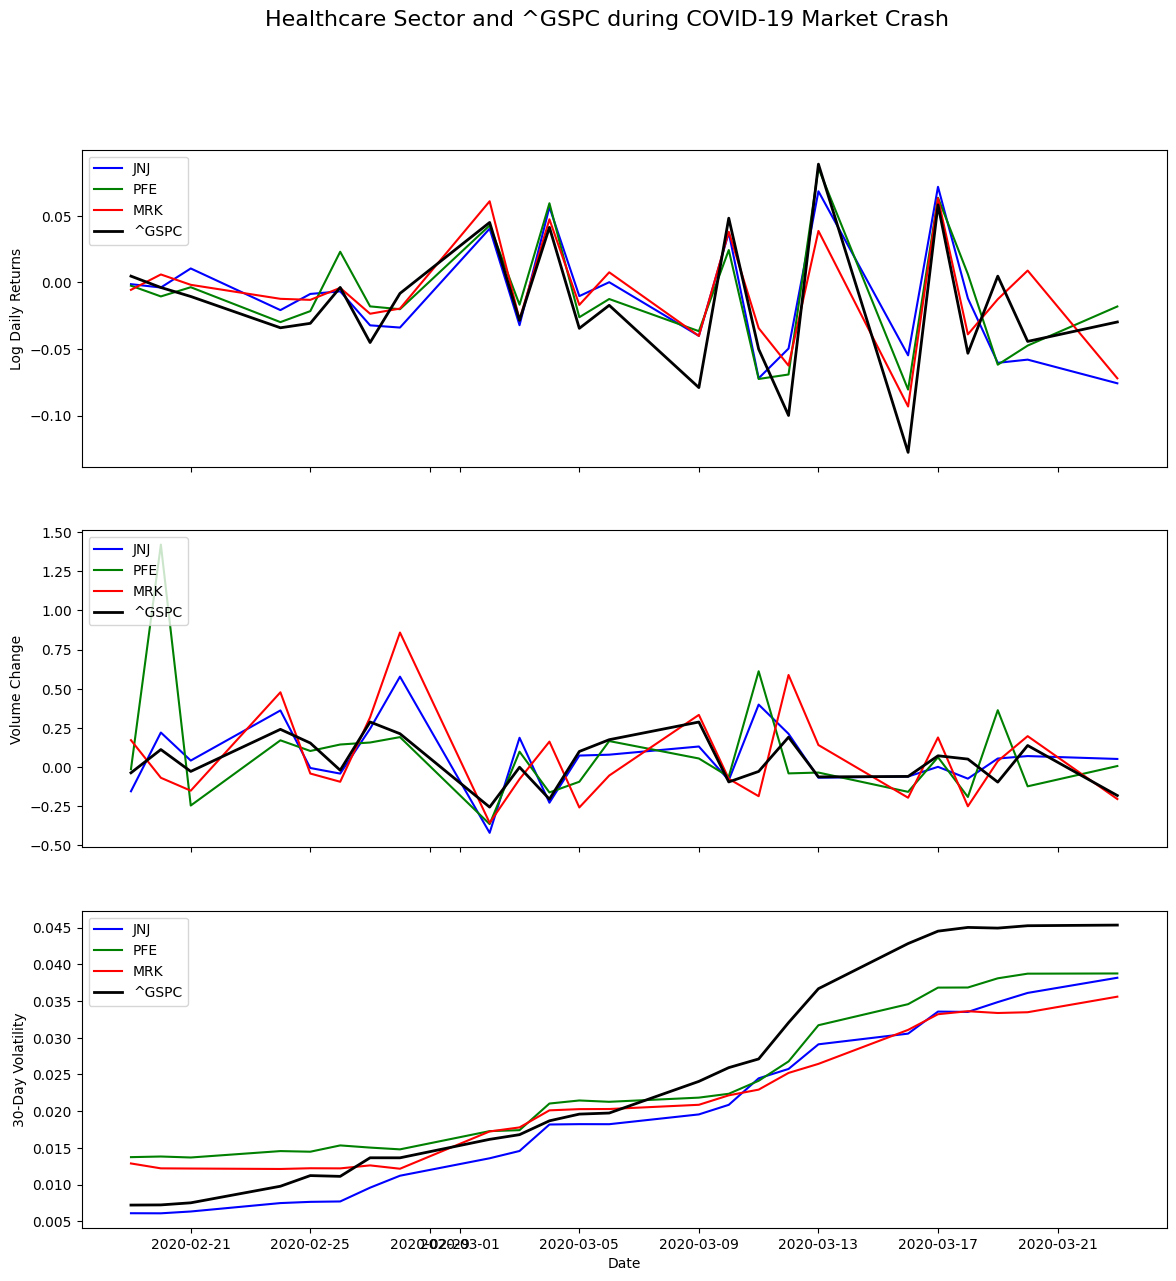

Correlations for Healthcare during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.309206          -0.161967   
Volume Change                     -0.309206       1.000000          -0.254705   
30-Day Volatility                 -0.161967      -0.254705           1.000000   
Market Log Daily Returns           0.890628      -0.172545          -0.089499   

                          Market Log Daily Returns  
Log Daily Returns                         0.890628  
Volume Change                            -0.172545  
30-Day Volatility                        -0.089499  
Market Log Daily Returns                  1.000000  



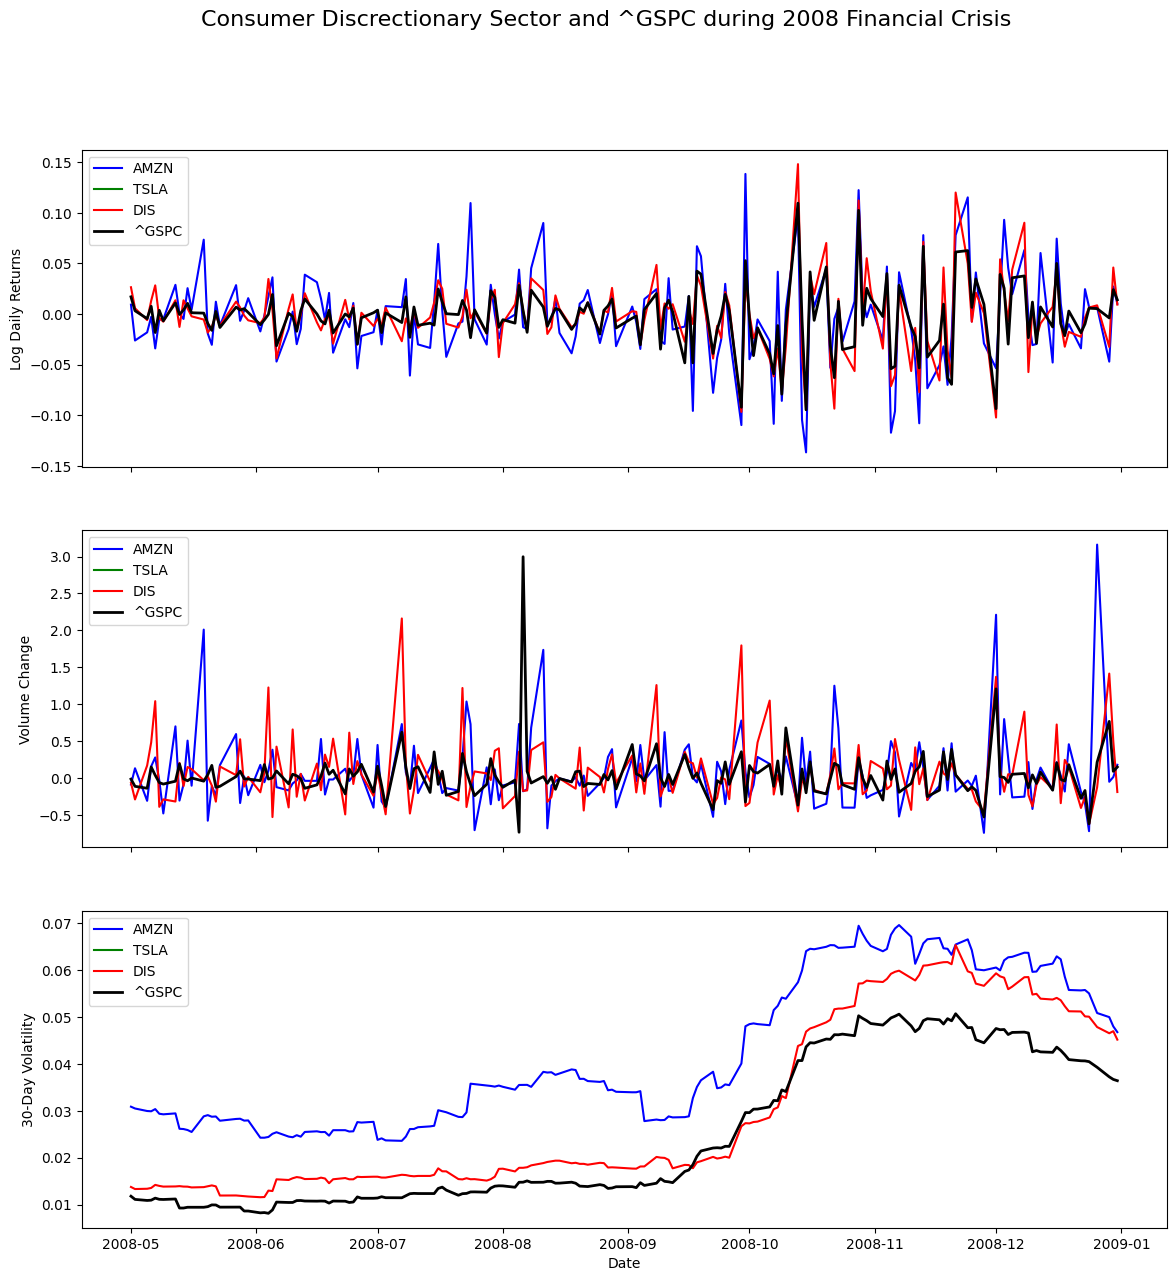

Correlations for Consumer Discrectionary during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.036272          -0.011008   
Volume Change                     -0.036272       1.000000          -0.007582   
30-Day Volatility                 -0.011008      -0.007582           1.000000   
Market Log Daily Returns           0.895879      -0.156727           0.003878   

                          Market Log Daily Returns  
Log Daily Returns                         0.895879  
Volume Change                            -0.156727  
30-Day Volatility                         0.003878  
Market Log Daily Returns                  1.000000  



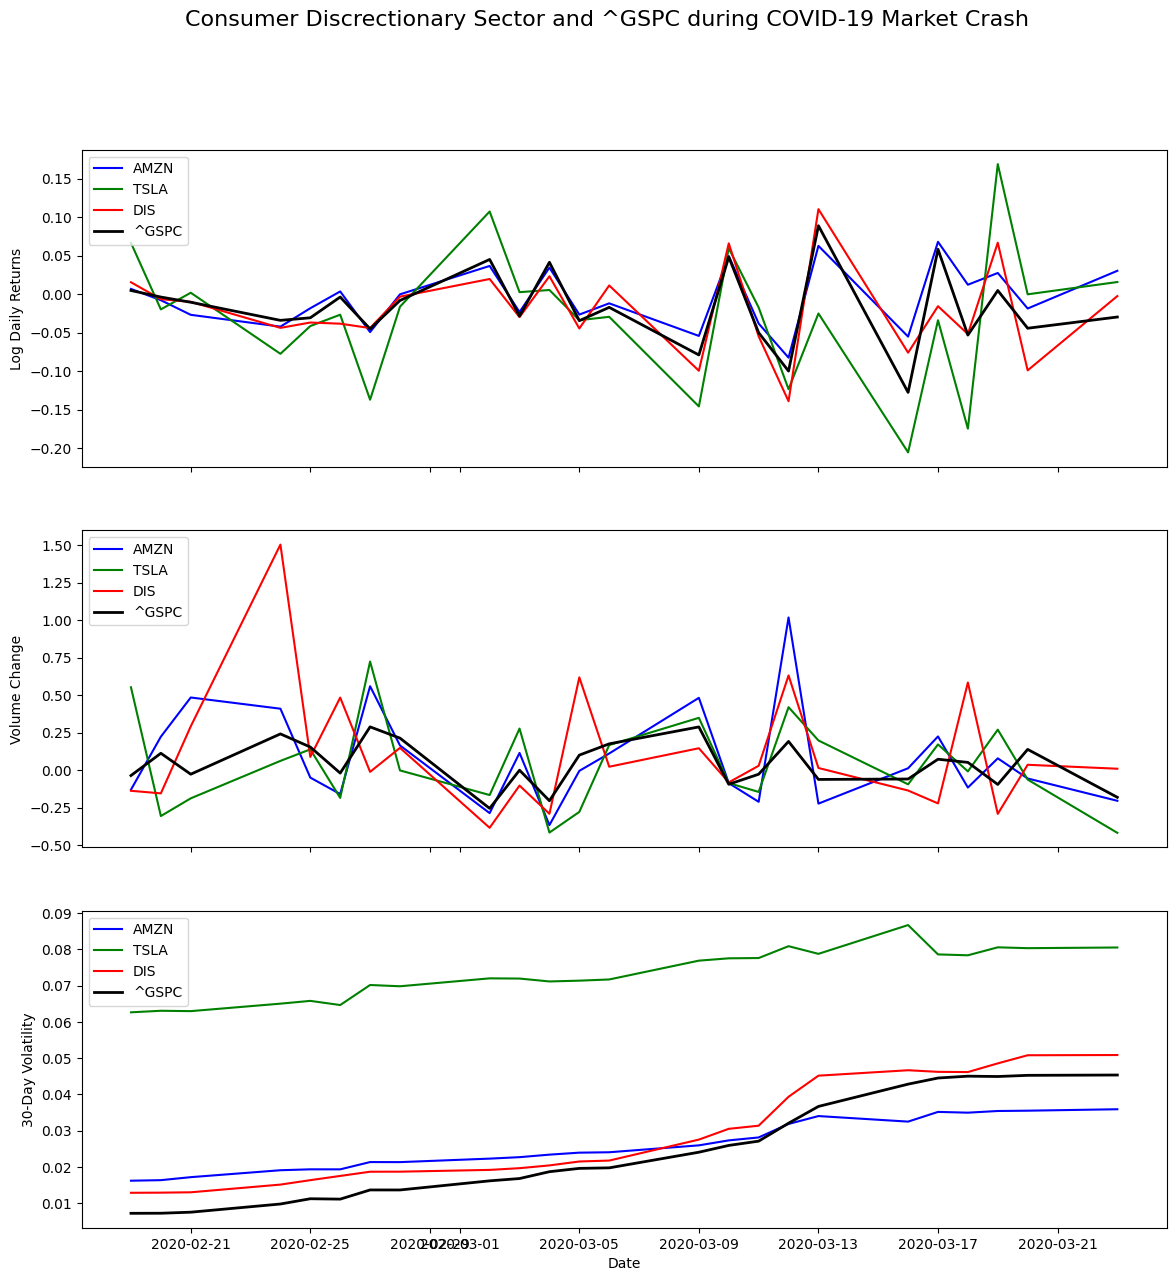

Correlations for Consumer Discrectionary during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.584921          -0.047846   
Volume Change                     -0.584921       1.000000          -0.143453   
30-Day Volatility                 -0.047846      -0.143453           1.000000   
Market Log Daily Returns           0.859443      -0.451620          -0.141330   

                          Market Log Daily Returns  
Log Daily Returns                         0.859443  
Volume Change                            -0.451620  
30-Day Volatility                        -0.141330  
Market Log Daily Returns                  1.000000  



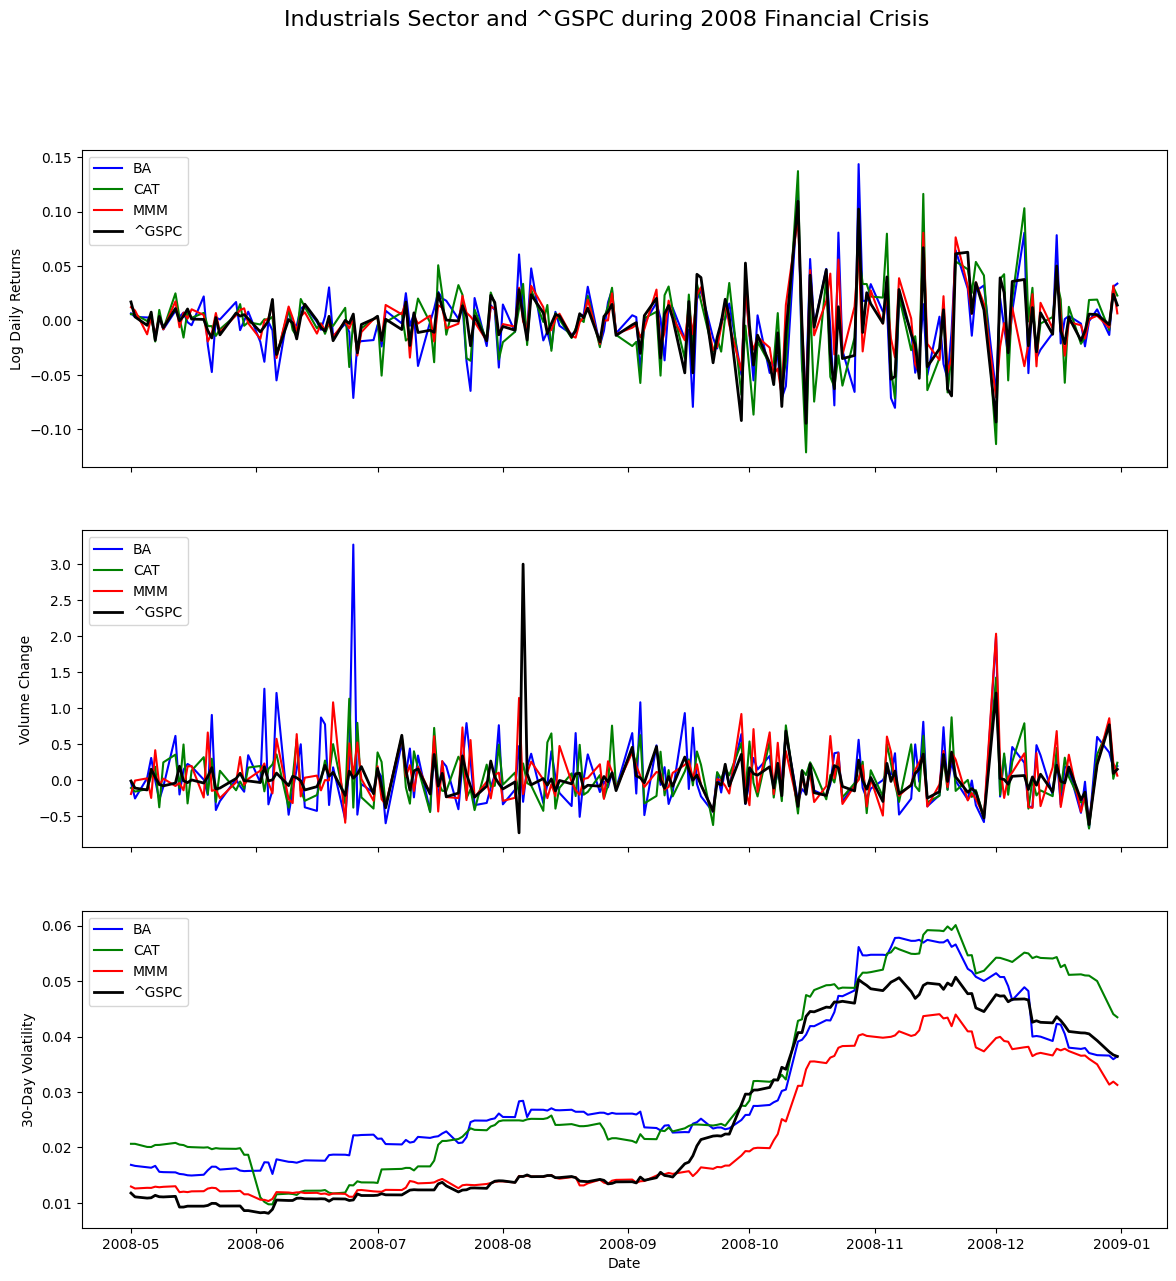

Correlations for Industrials during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.202999           0.044424   
Volume Change                     -0.202999       1.000000          -0.018716   
30-Day Volatility                  0.044424      -0.018716           1.000000   
Market Log Daily Returns           0.923465      -0.190696           0.011766   

                          Market Log Daily Returns  
Log Daily Returns                         0.923465  
Volume Change                            -0.190696  
30-Day Volatility                         0.011766  
Market Log Daily Returns                  1.000000  



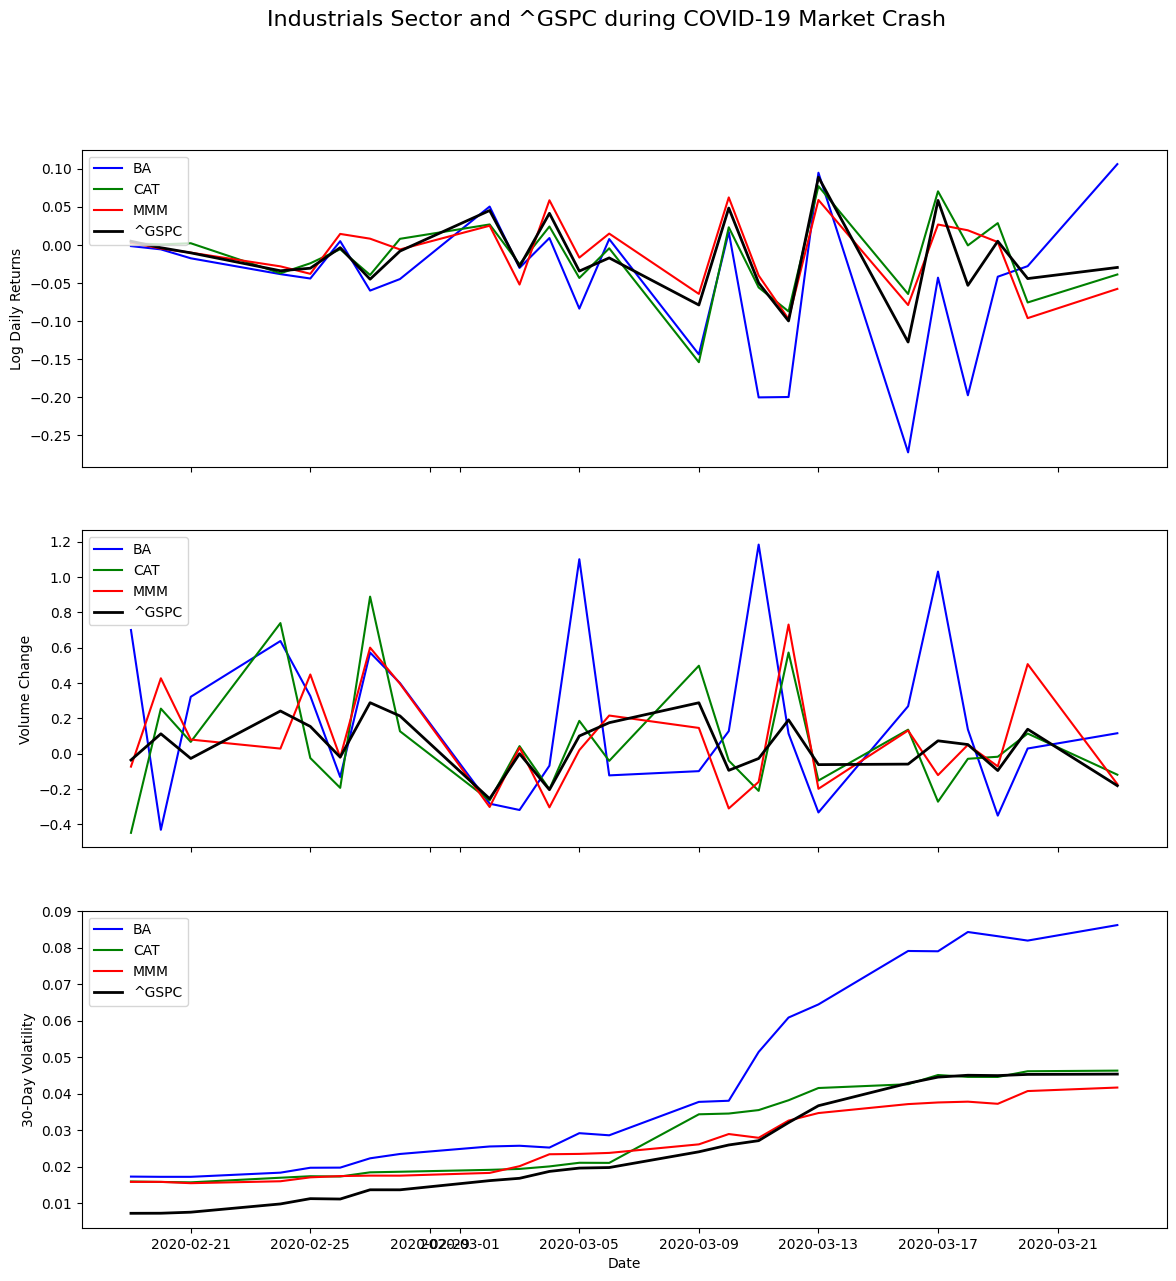

Correlations for Industrials during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.576566          -0.223579   
Volume Change                     -0.576566       1.000000          -0.128639   
30-Day Volatility                 -0.223579      -0.128639           1.000000   
Market Log Daily Returns           0.938689      -0.575151          -0.146163   

                          Market Log Daily Returns  
Log Daily Returns                         0.938689  
Volume Change                            -0.575151  
30-Day Volatility                        -0.146163  
Market Log Daily Returns                  1.000000  



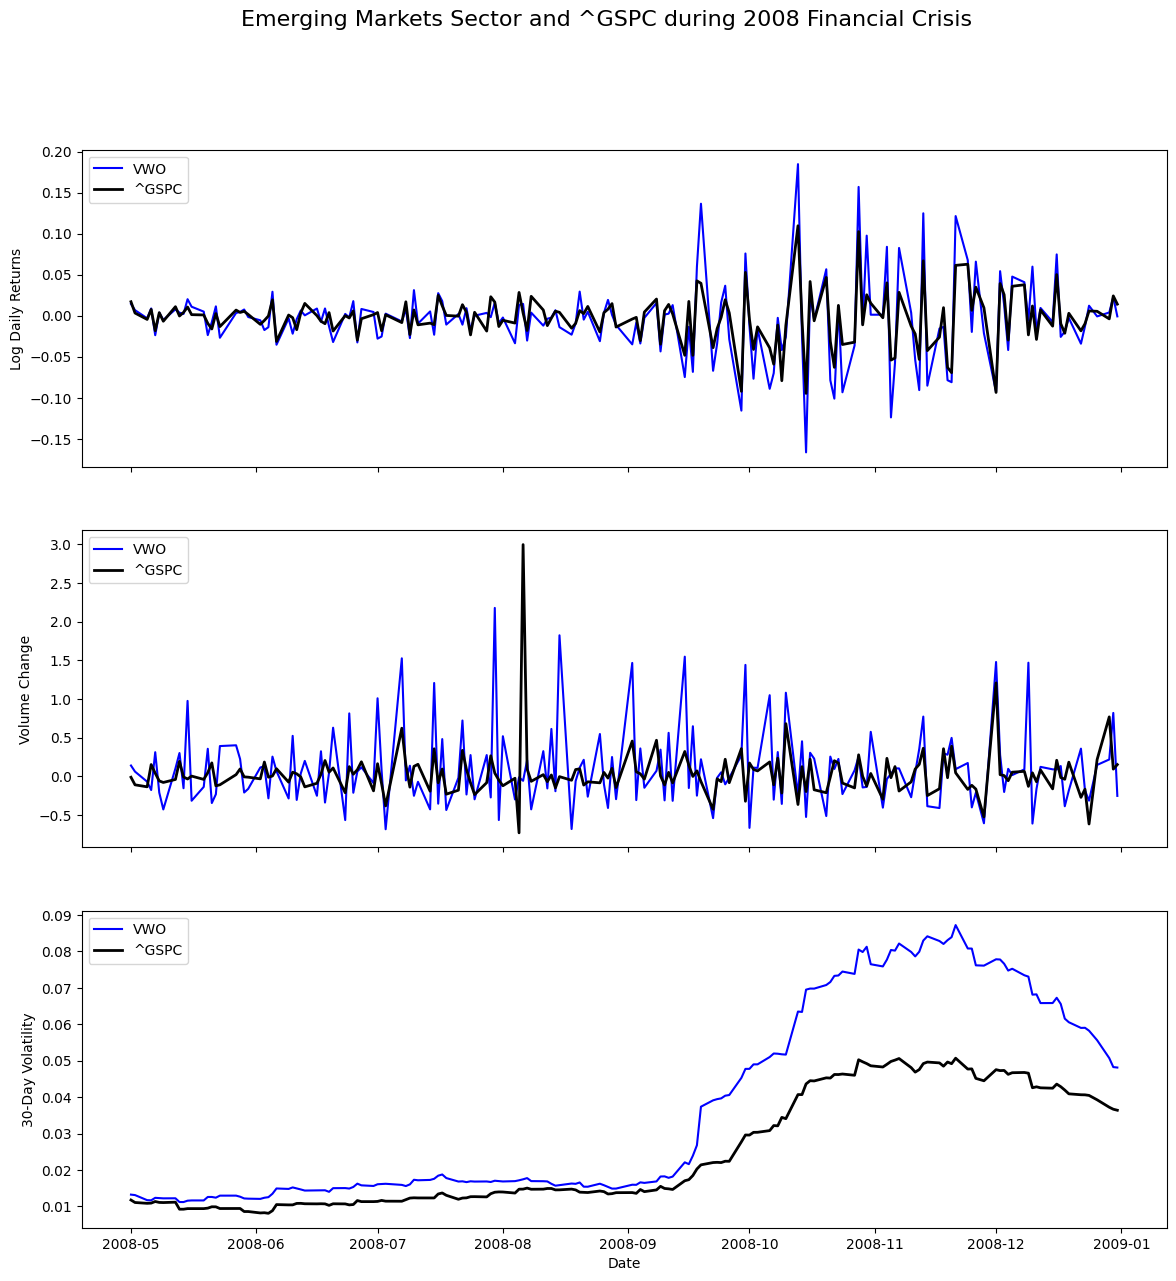

Correlations for Emerging Markets during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.081050           0.014742   
Volume Change                     -0.081050       1.000000          -0.020542   
30-Day Volatility                  0.014742      -0.020542           1.000000   
Market Log Daily Returns           0.908411      -0.054512          -0.016188   

                          Market Log Daily Returns  
Log Daily Returns                         0.908411  
Volume Change                            -0.054512  
30-Day Volatility                        -0.016188  
Market Log Daily Returns                  1.000000  



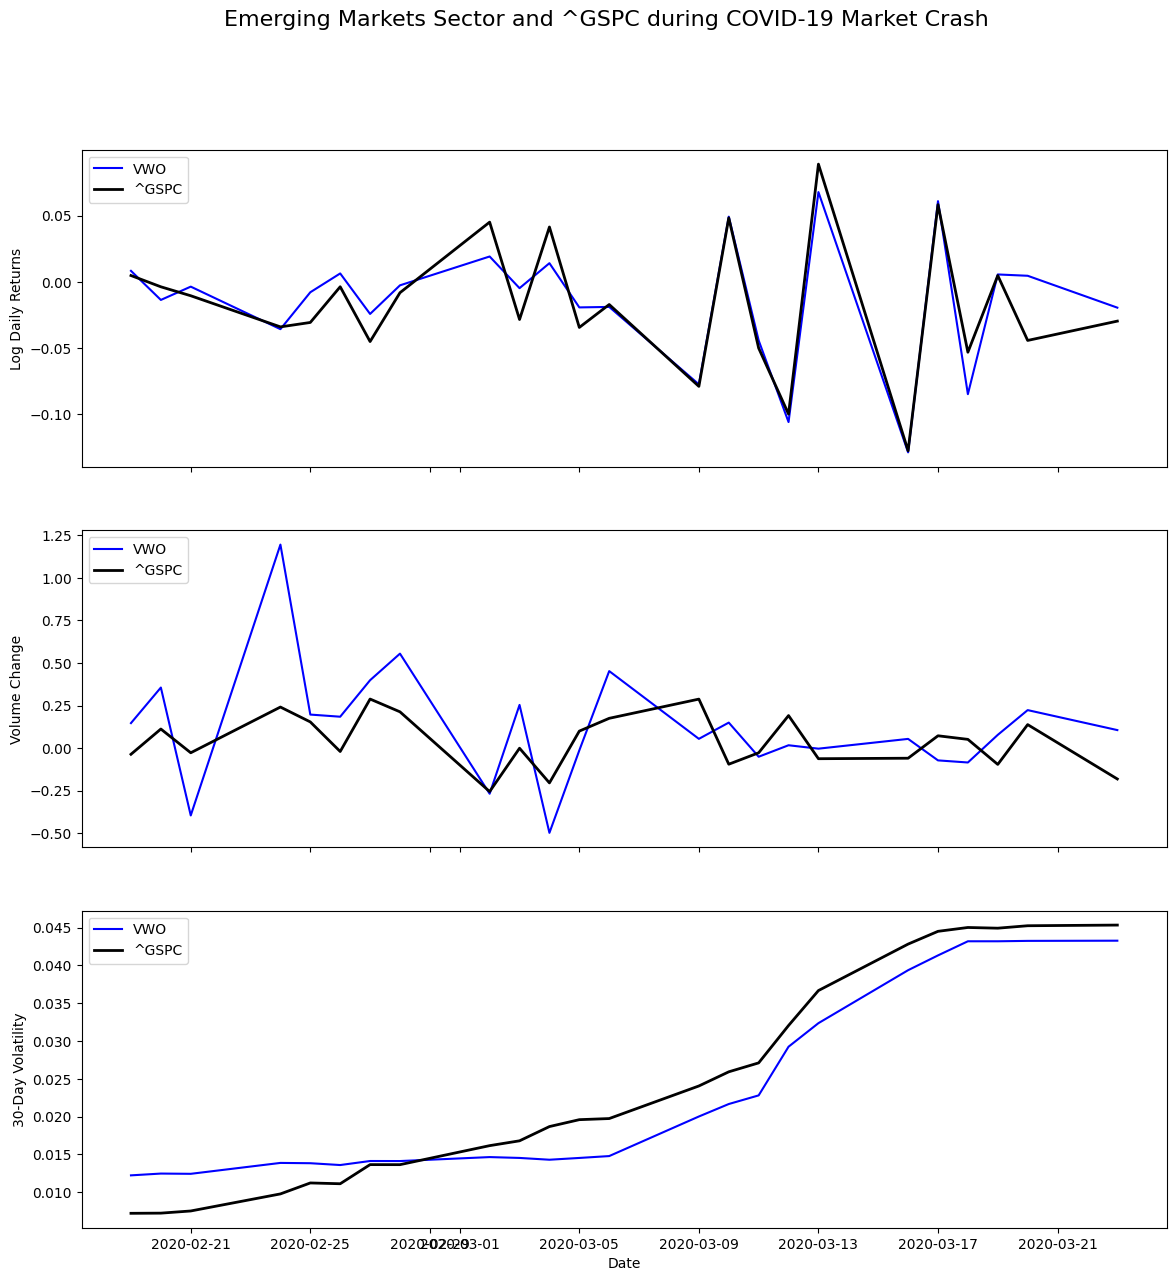

Correlations for Emerging Markets during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.093720          -0.140198   
Volume Change                     -0.093720       1.000000          -0.193111   
30-Day Volatility                 -0.140198      -0.193111           1.000000   
Market Log Daily Returns           0.934262      -0.201039          -0.130320   

                          Market Log Daily Returns  
Log Daily Returns                         0.934262  
Volume Change                            -0.201039  
30-Day Volatility                        -0.130320  
Market Log Daily Returns                  1.000000  



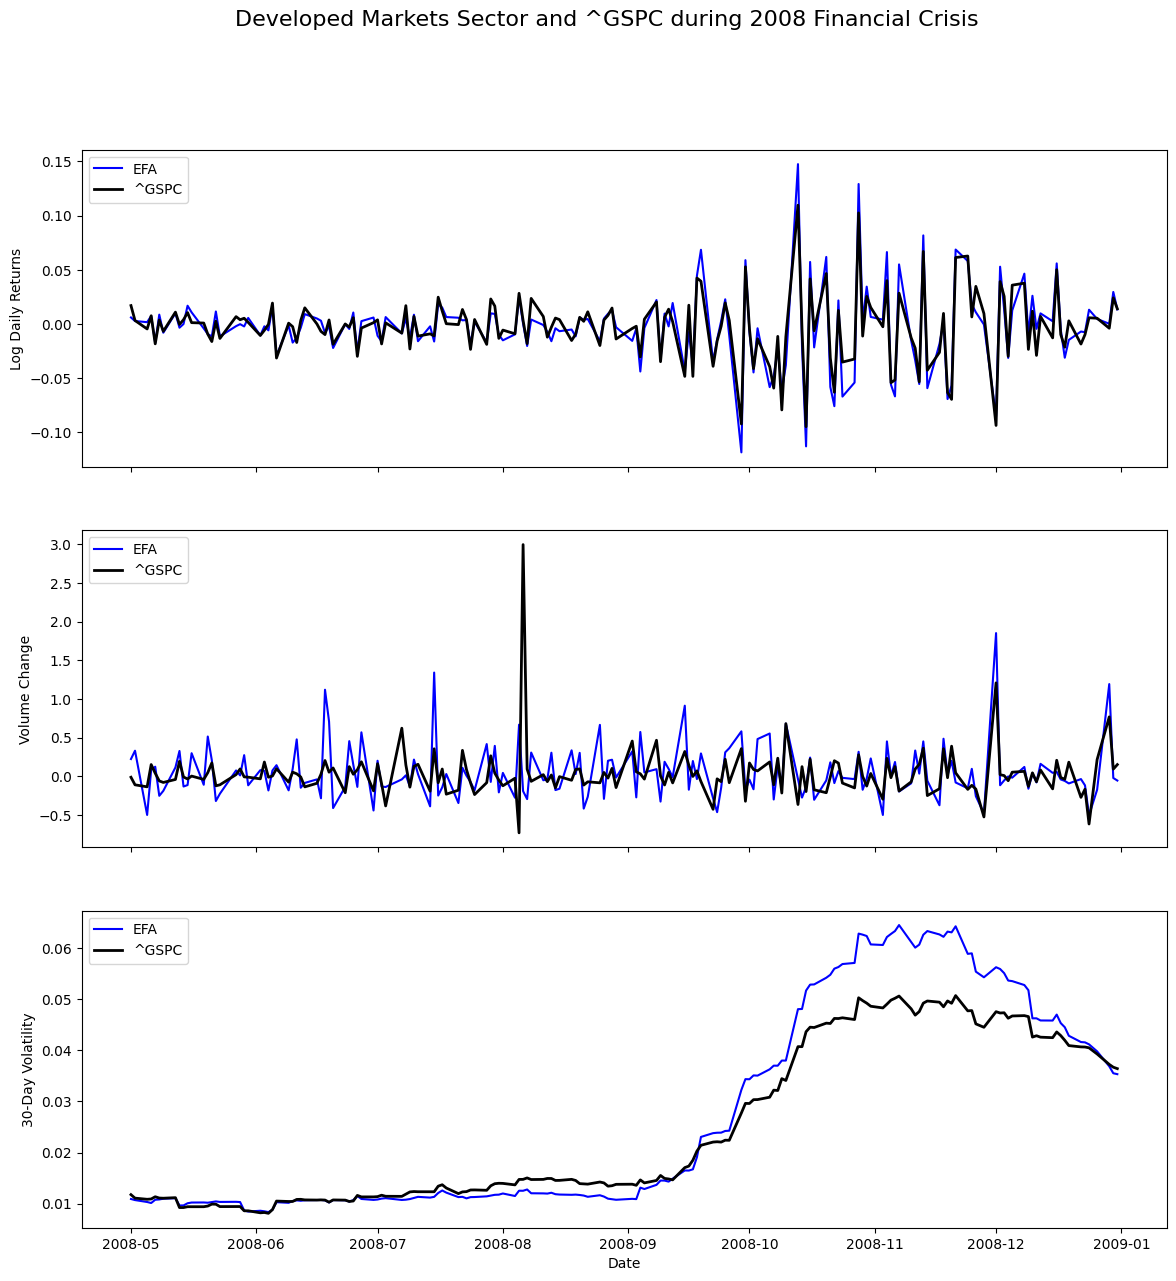

Correlations for Developed Markets during 2008 Financial Crisis:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.104546           0.011760   
Volume Change                     -0.104546       1.000000          -0.014441   
30-Day Volatility                  0.011760      -0.014441           1.000000   
Market Log Daily Returns           0.948119      -0.103763          -0.014950   

                          Market Log Daily Returns  
Log Daily Returns                         0.948119  
Volume Change                            -0.103763  
30-Day Volatility                        -0.014950  
Market Log Daily Returns                  1.000000  



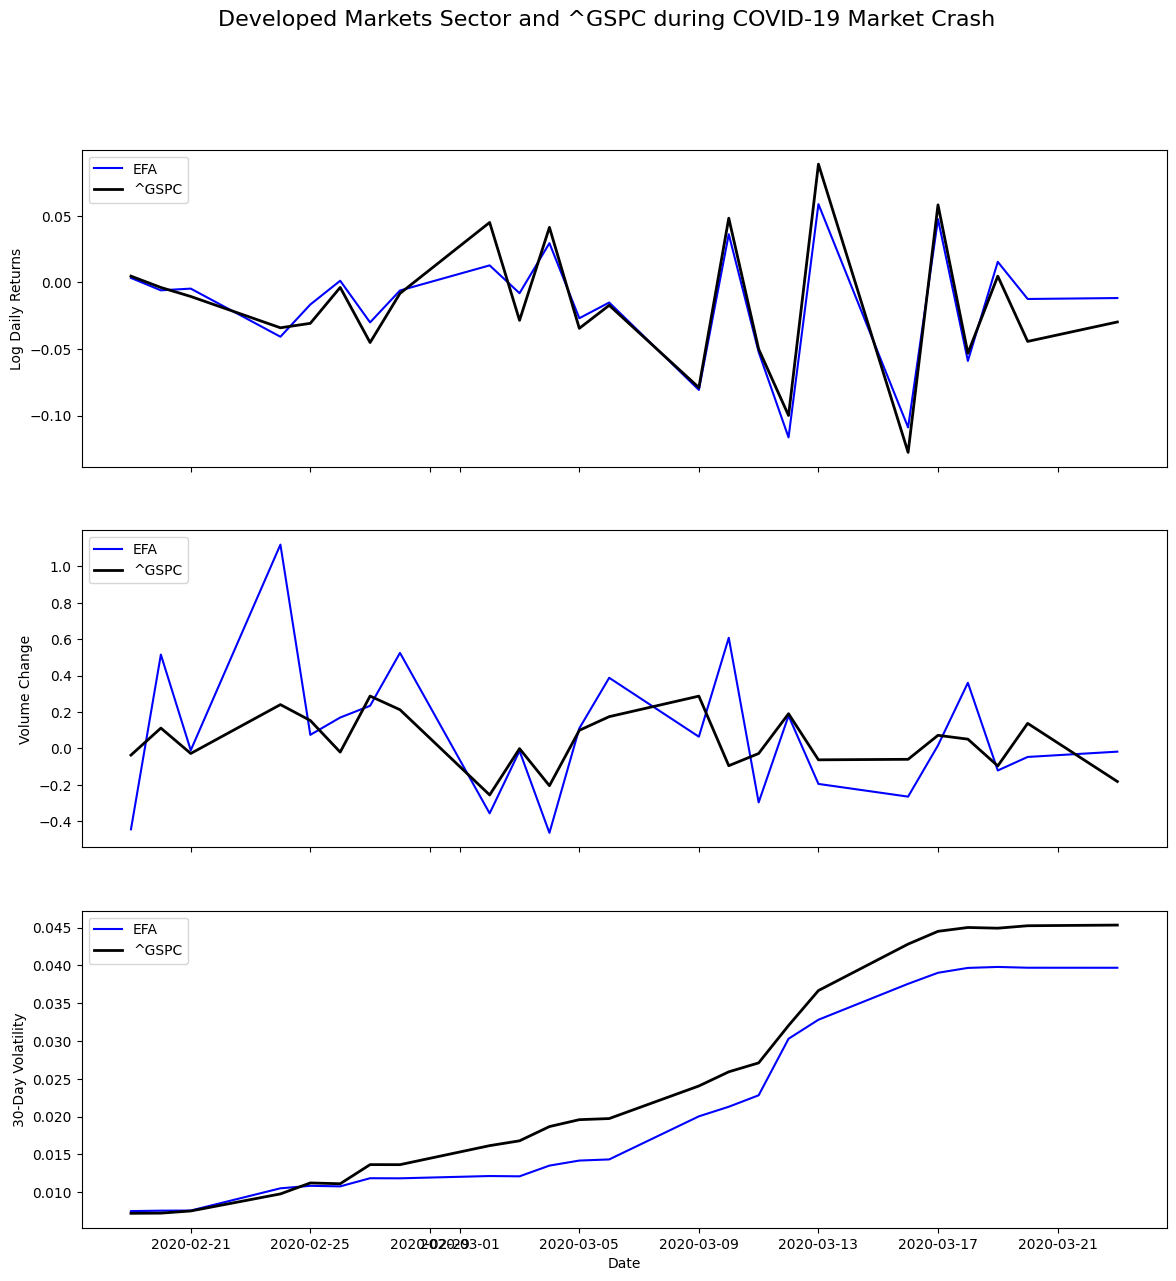

Correlations for Developed Markets during COVID-19 Market Crash:
                          Log Daily Returns  Volume Change  30-Day Volatility  \
Log Daily Returns                  1.000000      -0.124084          -0.120459   
Volume Change                     -0.124084       1.000000          -0.196046   
30-Day Volatility                 -0.120459      -0.196046           1.000000   
Market Log Daily Returns           0.954747      -0.111158          -0.136159   

                          Market Log Daily Returns  
Log Daily Returns                         0.954747  
Volume Change                            -0.111158  
30-Day Volatility                        -0.136159  
Market Log Daily Returns                  1.000000  



In [22]:
for sector, tickers in sector_classification.items():
    sector_tickers_data = {}
    sector_dfs = [] 
    
    for ticker in tickers:
        ticker_data = load_csv_data(ticker)
        if ticker_data is not None:
            sector_tickers_data[ticker] = ticker_data
            sector_dfs.append(ticker_data)
    
    # Calculate sector averages if there's at least one DataFrame
    sector_average_data = None  # Reset to None for each sector
    if sector_dfs:
        sector_average_data = pd.concat(sector_dfs).groupby(level=0).mean()
        sector_data[sector] = sector_average_data  
        
    for event_name, (start_date, end_date) in events.items():
        if sector_tickers_data:
            plot_sector_features(sector, sector_tickers_data, event_name, start_date, end_date, gspc_data)
        
        # Calculating and printing correlations for sector averages
        if sector_average_data is not None:
            calculate_correlations(sector, sector_average_data, gspc_data, event_name, start_date, end_date)

## Identify Number of Clusters
Using: Elbow Method and Silhouette Analysis

In [24]:
event_datasets = {}

for event_name, (start_date, end_date) in events.items():
    event_data = {}
    
    for ticker in all_tickers:
        data = load_csv_data(ticker)
        
        if data is not None:
            filtered_data = data.loc[start_date:end_date]
            
            if not filtered_data.empty:
                event_data[ticker] = filtered_data
    
    event_datasets[event_name] = event_data

In [25]:
print(event_datasets)

{'2008 Financial Crisis': {'^GSPC':                    Open         High          Low        Close    Adj Close  \
Date                                                                          
2008-05-01  1385.969971  1410.069946  1383.069946  1409.339966  1409.339966   
2008-05-02  1409.160034  1422.719971  1406.250000  1413.900024  1413.900024   
2008-05-05  1415.339966  1415.339966  1404.369995  1407.489990  1407.489990   
2008-05-06  1405.599976  1421.569946  1397.099976  1418.260010  1418.260010   
2008-05-07  1417.489990  1419.540039  1391.160034  1392.569946  1392.569946   
...                 ...          ...          ...          ...          ...   
2008-12-24   863.869995   869.789978   861.440002   868.150024   868.150024   
2008-12-26   869.510010   873.739990   866.520020   872.799988   872.799988   
2008-12-29   872.369995   873.700012   857.070007   869.419983   869.419983   
2008-12-30   870.580017   891.119995   870.580017   890.640015   890.640015   
2008-12-31   890

In [26]:
scaled_event_data = {}

scaler = StandardScaler()

# MinMaxScaler instance for scaling '30-Day Volatility'
min_max_scaler = MinMaxScaler()

for event_name, ticker_data in event_datasets.items():
    all_scaled_data = []
    
    for ticker, data in ticker_data.items():
        if data.empty:
            continue  
        
        features_data = data[features]
        
        # Scale using Standard Scaler for Others
        scaled_features = scaler.fit_transform(features_data.drop(columns=['30-Day Volatility']))
        scaled_volatility = min_max_scaler.fit_transform(features_data[['30-Day Volatility']])
        scaled_features = np.concatenate([scaled_features, scaled_volatility], axis=1)
        
        scaled_df = pd.DataFrame(scaled_features, index=data.index, columns=features)
        scaled_df['Ticker'] = ticker
        all_scaled_data.append(scaled_df)
    
    event_scaled_df = pd.concat(all_scaled_data)
    scaled_event_data[event_name] = event_scaled_df


In [27]:
# checker to ensure correct scaling

for event_name, scaled_data in scaled_event_data.items():
    print(f"Scaled Data for {event_name}:")
    print(scaled_data.describe())

Scaled Data for 2008 Financial Crisis:
       Log Daily Returns  Volume Change  30-Day Volatility
count       4.250000e+03   4.250000e+03        4250.000000
mean       -1.044916e-18  -6.687461e-18           0.392926
std         1.000118e+00   9.592792e-01           0.346378
min        -6.295814e+00  -2.714971e+00           0.000000
25%        -4.657441e-01  -5.671252e-01           0.088746
50%         2.249497e-02  -6.802743e-02           0.220651
75%         4.653275e-01   3.390171e-01           0.774615
max         5.349558e+00   9.456668e+00           1.000000
Scaled Data for COVID-19 Market Crash:
       Log Daily Returns  Volume Change  30-Day Volatility
count       6.240000e+02   6.240000e+02         624.000000
mean       -3.558407e-18   4.270089e-18           0.425890
std         1.000802e+00   9.813673e-01           0.360819
min        -2.772522e+00  -2.349161e+00           0.000000
25%        -5.327364e-01  -6.725246e-01           0.101788
50%         1.263979e-02  -1.338599e-

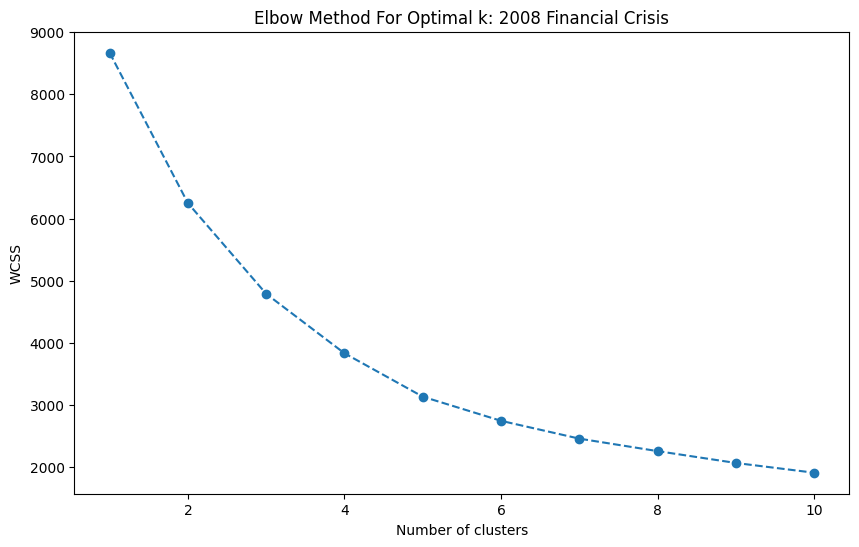

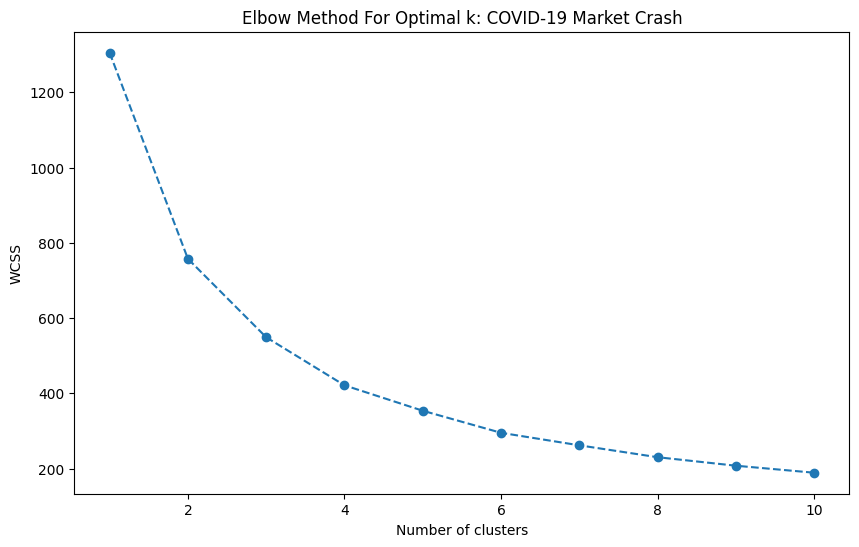

In [28]:
wcss_event = {}

for event_name, scaled_data in scaled_event_data.items():
    wcss = []
    
    # try clustering with 1 to 10 clusters
    for i in range(1, 11):
        # Initialize and fit a KMeans instance for the current number of clusters
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
        kmeans.fit(scaled_data.drop('Ticker', axis=1)) 
        
        wcss.append(kmeans.inertia_)
    
    wcss_event[event_name] = wcss
    
    # Plot the Elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title(f'Elbow Method For Optimal k: {event_name}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

Since the line begins to level off around 4, the elbow method seems to indicate that the optimal number of clusters is around 4

C:\Users\egodd\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster assignments for 2008 Financial Crisis:
^GSPC: Cluster 1
^DJI: Cluster 1
^IXIC: Cluster 0
^RUT: Cluster 1
^SP400: Cluster 1
^SP600: Cluster 1
SPY: Cluster 1
VTI: Cluster 1
QQQ: Cluster 0
VWO: Cluster 1
EFA: Cluster 1
AAPL: Cluster 1
MSFT: Cluster 0
NVDA: Cluster 1
JPM: Cluster 1
BAC: Cluster 0
GS: Cluster 1
JNJ: Cluster 1
PFE: Cluster 1
MRK: Cluster 1
AMZN: Cluster 1
DIS: Cluster 1
BA: Cluster 1
CAT: Cluster 1
MMM: Cluster 1

Cluster centroids:
   Log Daily Returns  Volume Change  30-Day Volatility
0           1.481092       0.142448           0.660268
1           0.061829      -0.316642           0.266040
2          -1.305548       0.009608           0.619847
3          -0.582618       2.309465           0.330533


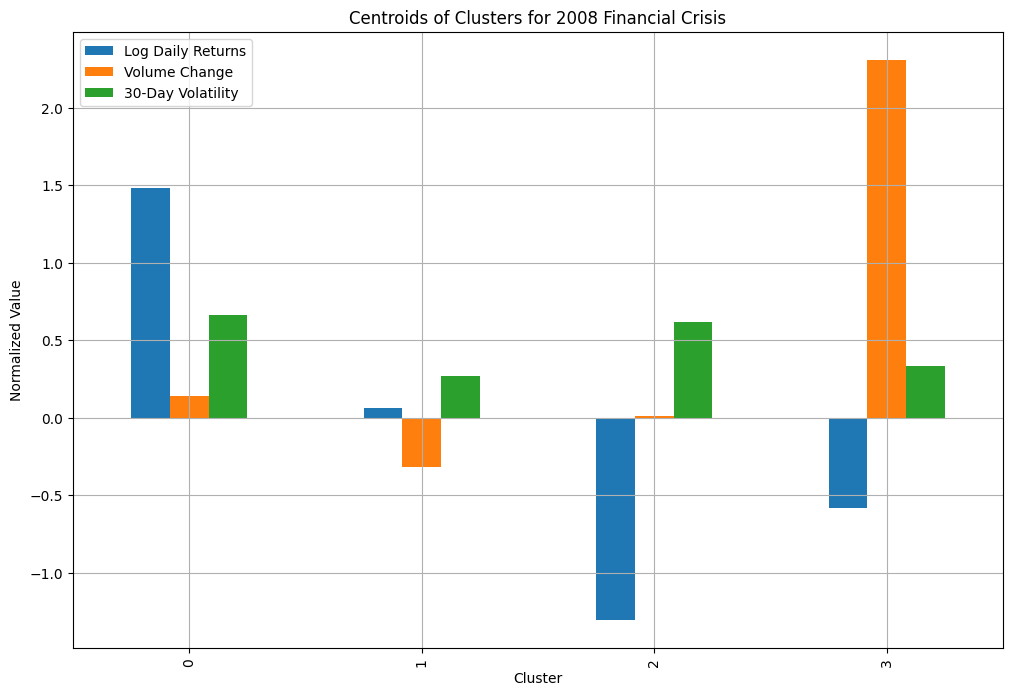


Cluster characteristics for 2008 Financial Crisis:
         Log Daily Returns  Volume Change  30-Day Volatility
Cluster                                                     
0                 1.481092       0.142448           0.660268
1                 0.061829      -0.316642           0.266040
2                -1.305548       0.009608           0.619847
3                -0.582618       2.309465           0.330533

Cluster assignments for COVID-19 Market Crash:
^GSPC: Cluster 1
^DJI: Cluster 1
^IXIC: Cluster 1
^RUT: Cluster 1
^SP400: Cluster 1
^SP600: Cluster 1
SPY: Cluster 1
VTI: Cluster 1
QQQ: Cluster 1
VWO: Cluster 1
EFA: Cluster 2
AAPL: Cluster 2
MSFT: Cluster 1
NVDA: Cluster 1
JPM: Cluster 2
BAC: Cluster 2
GS: Cluster 2
JNJ: Cluster 1
PFE: Cluster 1
MRK: Cluster 1
AMZN: Cluster 1
TSLA: Cluster 3
DIS: Cluster 2
BA: Cluster 3
CAT: Cluster 2
MMM: Cluster 1

Cluster centroids:
   Log Daily Returns  Volume Change  30-Day Volatility
0          -1.546681       0.100646           0.759504

C:\Users\egodd\AppData\Local\Temp\ipykernel_26004\3672618369.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_characteristics = scaled_data.groupby('Cluster').mean()
C:\Users\egodd\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


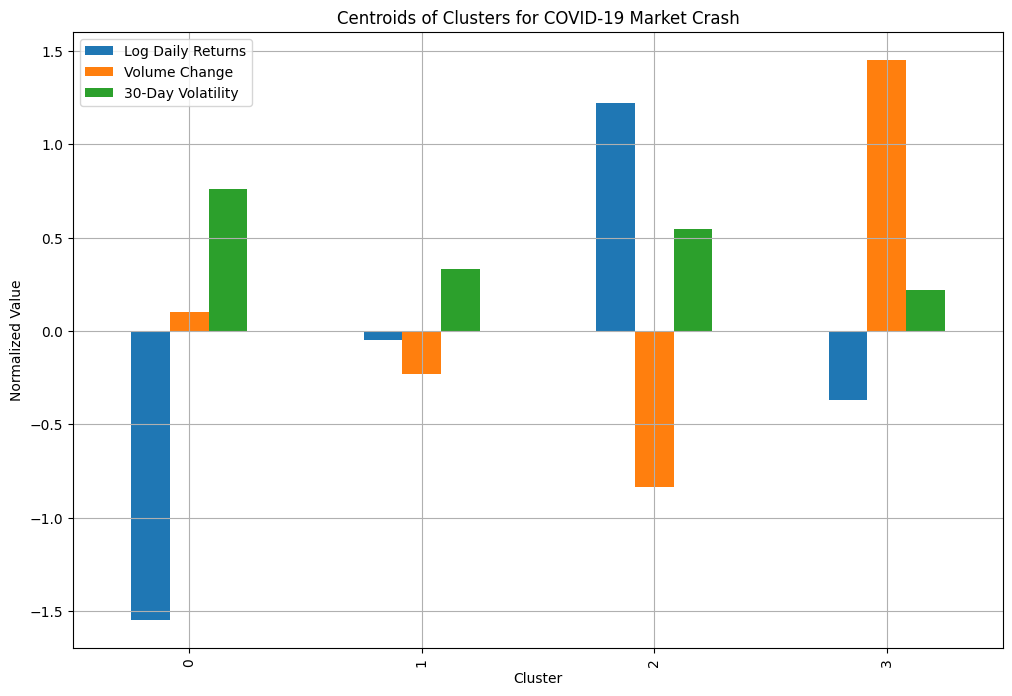


Cluster characteristics for COVID-19 Market Crash:
         Log Daily Returns  Volume Change  30-Day Volatility
Cluster                                                     
0                -1.546681       0.100646           0.759504
1                -0.050497      -0.229513           0.332822
2                 1.222816      -0.838096           0.547062
3                -0.370600       1.451549           0.218595



C:\Users\egodd\AppData\Local\Temp\ipykernel_26004\3672618369.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cluster_characteristics = scaled_data.groupby('Cluster').mean()


In [29]:
n_clusters = 4
clustering_results = {}

for event_name, scaled_data in scaled_event_data.items():
    X = scaled_data.drop(['Ticker', 'Cluster'], axis=1, errors='ignore').values
    
    # Perform k-means clustering
    kmeans = KMeans(n_clusters, random_state=42)
    kmeans.fit(X)
    
    # Store the Cluster Labels and data
    scaled_data['Cluster'] = kmeans.labels_
    clustering_results[event_name] = scaled_data
    
    # Output the cluster assignment for each stock
    print(f"Cluster assignments for {event_name}:")
    for ticker in scaled_data['Ticker'].unique():
        cluster = scaled_data[scaled_data['Ticker'] == ticker]['Cluster'].iloc[0]
        print(f"{ticker}: Cluster {cluster}")
    
    # Print out the centroids in a cleaner fashion
    print("\nCluster centroids:")
    centroids = pd.DataFrame(kmeans.cluster_centers_, columns=scaled_data.drop(['Ticker', 'Cluster'], axis=1, errors='ignore').columns)  # Use the same feature columns that were used for clustering
    print(centroids)
    
    # Centroids viz
    centroids.plot(kind='bar', figsize=(12, 8))
    plt.title(f'Centroids of Clusters for {event_name}')
    plt.xlabel('Cluster')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.show()
    
    # cluster characteristics
    cluster_characteristics = scaled_data.groupby('Cluster').mean()
    print(f"\nCluster characteristics for {event_name}:\n{cluster_characteristics}\n")

In [30]:
print(clustering_results)

{'2008 Financial Crisis':             Log Daily Returns  Volume Change  30-Day Volatility Ticker  \
Date                                                                     
2008-05-01           0.654990      -0.148223           0.085703  ^GSPC   
2008-05-02           0.192925      -0.457052           0.069696  ^GSPC   
2008-05-05          -0.068040      -0.538624           0.064437  ^GSPC   
2008-05-06           0.340370       0.368246           0.065814  ^GSPC   
2008-05-07          -0.529127       0.015489           0.076115  ^GSPC   
...                       ...            ...                ...    ...   
2008-12-24           0.104760      -1.803163           0.760985    MMM   
2008-12-26           0.232055       0.475841           0.731810    MMM   
2008-12-29          -0.200039       2.249800           0.623249    MMM   
2008-12-30           1.321621       0.531934           0.639083    MMM   
2008-12-31           0.316126       0.024173           0.621343    MMM   

           

In [31]:
cluster_returns = {}
for event in ['2008 Financial Crisis', 'COVID-19 Market Crash']:
    cluster_returns[event] = (clustering_results[event].groupby('Cluster')['Log Daily Returns'].mean())/(clustering_results[event].groupby('Cluster')['30-Day Volatility'].mean())

# Determine the optimal cluster (with highest average returns to 30-day vol) for each event
optimal_clusters = {}
for event in ['2008 Financial Crisis', 'COVID-19 Market Crash']:
    optimal_clusters[event] = cluster_returns[event].idxmax()

optimal_tickers = set()
for ticker in clustering_results['2008 Financial Crisis']['Ticker'].unique():
    if ticker in clustering_results['COVID-19 Market Crash']['Ticker'].unique():
        cluster_2008 = clustering_results['2008 Financial Crisis'][clustering_results['2008 Financial Crisis']['Ticker'] == ticker]['Cluster'].iloc[0]
        cluster_covid = clustering_results['COVID-19 Market Crash'][clustering_results['COVID-19 Market Crash']['Ticker'] == ticker]['Cluster'].iloc[0]
        if cluster_2008 == optimal_clusters['2008 Financial Crisis'] and cluster_covid == optimal_clusters['COVID-19 Market Crash']:
            optimal_tickers.add(ticker)

print("Tickers in the optimal cluster (with highest average returns) in both events:", optimal_tickers)

Tickers in the optimal cluster (with highest average returns) in both events: {'BAC'}
